    item_id  year  month  seq  type   hs4    weight  quantity     value
0  DEWLVASR  2022      1  1.0     1  3038   14858.0       0.0   32688.0
1  ELQGMQWE  2022      1  1.0     1  2002   62195.0       0.0  110617.0
2  AHMDUILJ  2022      1  1.0     1  2102   18426.0       0.0   72766.0
3  XIPPENFQ  2022      1  1.0     1  2501   20426.0       0.0   11172.0
4  FTSVTTSR  2022      1  1.0     1  2529  248000.0       0.0  143004.0
(10836, 9)
Date Range: 2022-01-01 00:00:00 → 2025-07-01 00:00:00
TSCollection contains 100 time series.


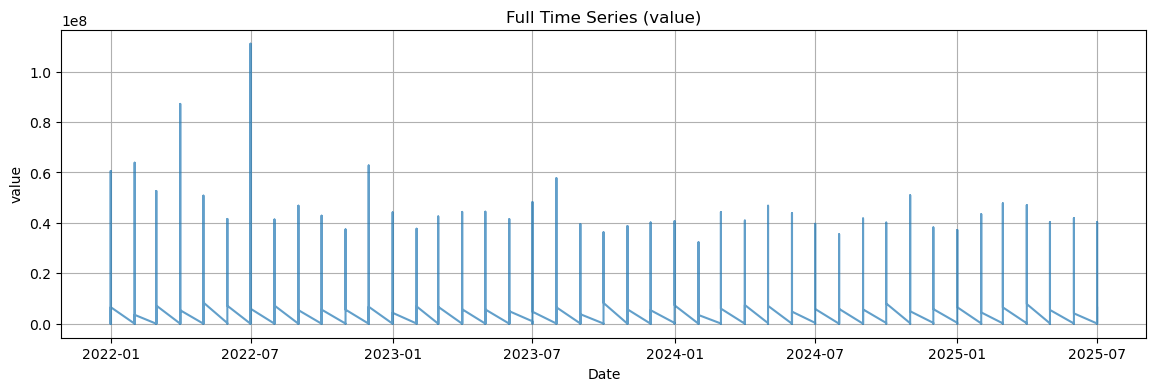

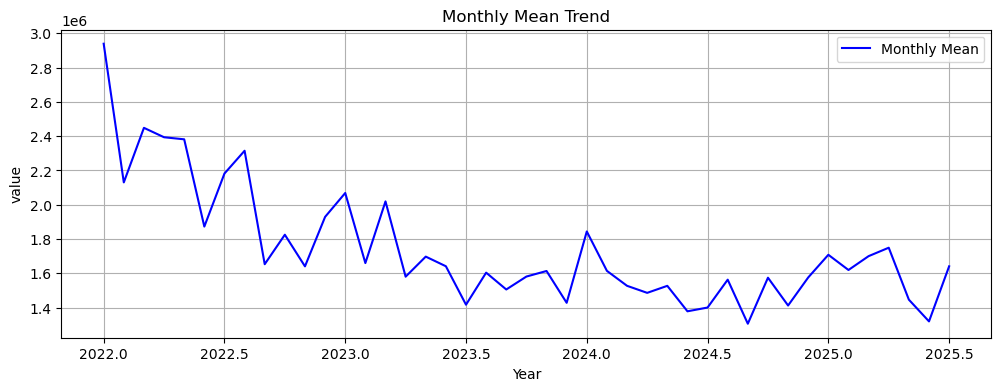

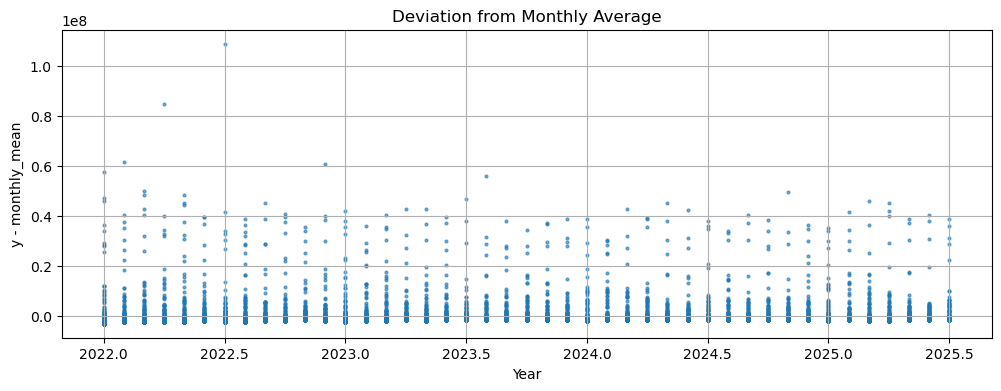

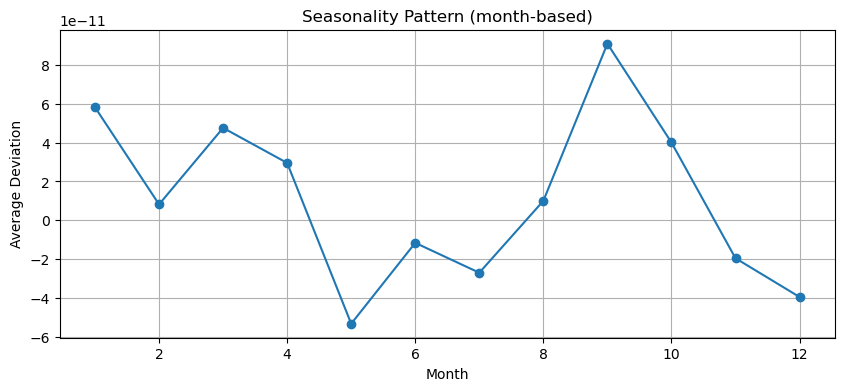

In [6]:
# =============================================
# 1. 데이터 로드
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import to_datetime
import seaborn as sns

df = pd.read_csv("open/train.csv")

print(df.head())
print(df.shape)


# =============================================
# 2. 정확한 날짜(year, month → timestamp)
# =============================================
df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))

# 기간 확인 (2022-01 ~ 2025-07인지 검사)
print("Date Range:", df.date.min(), "→", df.date.max())


# =============================================
# 3. 타깃 선택 (quantity, weight, value 중 원하는 것)
# =============================================
target = "value"


# =============================================
# 4. ts 구조 만들기 (MATLAB의 timeseries 흉내)
# =============================================
class TimeSeries:
    def __init__(self, data, time, name="ts"):
        self.data = np.array(data)
        self.time = np.array(time)
        self.name = name

ts = TimeSeries(
    data=df[target].values,
    time=df["date"].values,
    name=f"{target}_ts"
)


# =============================================
# 5. item_id별 tscollection 생성
# =============================================
class TSCollection:
    def __init__(self, dict_of_ts):
        self.ts_dict = dict_of_ts

item_ts_dict = {}
for item in df["item_id"].unique():
    tmp = df[df["item_id"] == item]
    item_ts_dict[item] = TimeSeries(
        data=tmp[target].values,
        time=tmp["date"].values,
        name=f"item_{item}"
    )

tscol = TSCollection(item_ts_dict)

print(f"TSCollection contains {len(tscol.ts_dict)} time series.")


# =============================================
# 6. 전체 타임라인 시각화
# =============================================
plt.figure(figsize=(14,4))
plt.plot(ts.time, ts.data, alpha=0.7)
plt.title(f"Full Time Series ({target})")
plt.xlabel("Date")
plt.ylabel(target)
plt.grid(True)
plt.show()


# =============================================
# 7. 월별 평균과 계절성 분석
# =============================================
df["year_fraction"] = df["year"] + (df["month"]-1)/12

# 월별 평균
monthly_mean = df.groupby(["year","month"])[target].mean().reset_index()
monthly_mean["year_fraction"] = monthly_mean["year"] + (monthly_mean["month"] - 1)/12

# 월별 편차
df = df.merge(
    monthly_mean[["year","month",target]].rename(columns={target:"mean_val"}),
    on=["year","month"],
    how="left"
)
df["ydiff"] = df[target] - df["mean_val"]


# =============================================
# 8. 월별 평균 추세 그리기
# =============================================
x = monthly_mean["year_fraction"].values
y = monthly_mean[target].values

plt.figure(figsize=(12,4))
plt.plot(x, y, "b-", label="Monthly Mean")
plt.title("Monthly Mean Trend")
plt.xlabel("Year")
plt.ylabel(target)
plt.grid(True)
plt.legend()
plt.show()


# =============================================
# 9. 월별 deviation(잔차) 시각화
# =============================================
plt.figure(figsize=(12,4))
plt.scatter(df["year_fraction"], df["ydiff"], s=4, alpha=0.6)
plt.title("Deviation from Monthly Average")
plt.xlabel("Year")
plt.ylabel("y - monthly_mean")
plt.grid(True)
plt.show()


# =============================================
# 10. 월별 Seasonality 계산 (전체 평균)
# =============================================
seasonality = df.groupby("month")["ydiff"].mean()

plt.figure(figsize=(10,4))
plt.plot(seasonality.index, seasonality.values, marker="o")
plt.title("Seasonality Pattern (month-based)")
plt.xlabel("Month")
plt.ylabel("Average Deviation")
plt.grid(True)
plt.show()

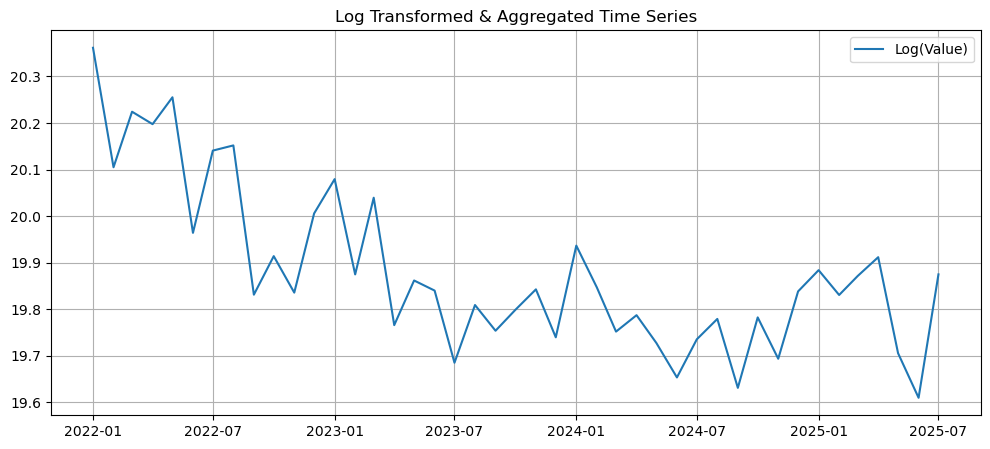

ADF Statistic: -2.2913
p-value: 0.1748
>> 시계열이 비정상(Non-stationary)입니다. 차분이나 추세 제거가 필요합니다.


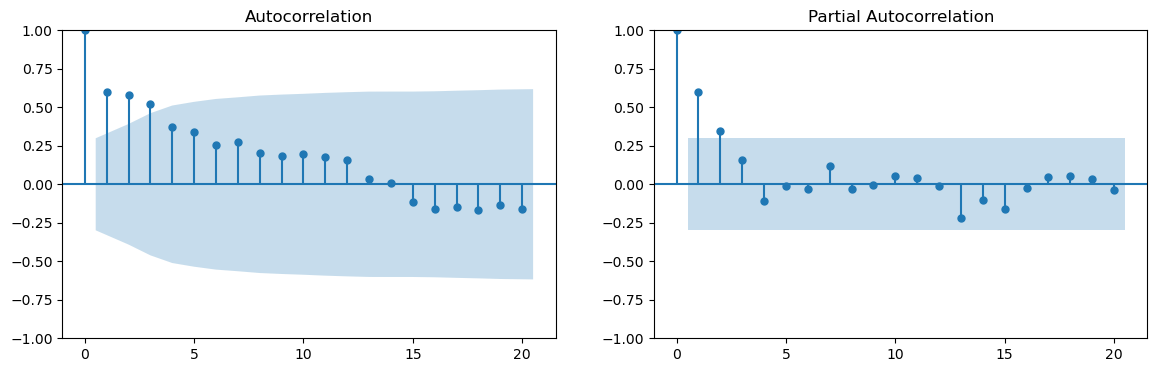

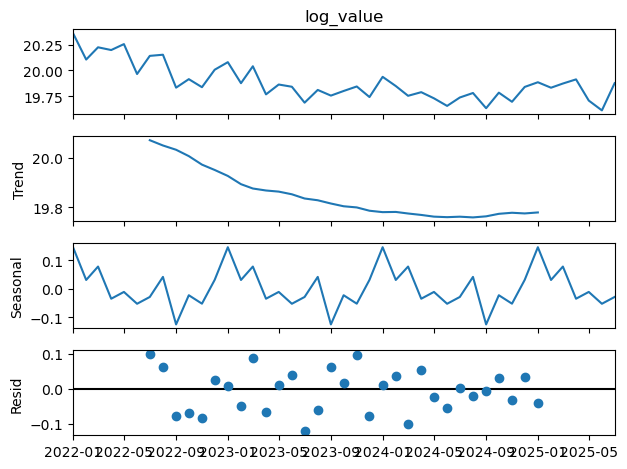

                            OLS Regression Results                            
Dep. Variable:              log_value   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     5.860
Date:                Tue, 25 Nov 2025   Prob (F-statistic):           4.12e-05
Time:                        20:20:39   Log-Likelihood:                 39.695
No. Observations:                  43   AIC:                            -53.39
Df Residuals:                      30   BIC:                            -30.49
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             20.2391      0

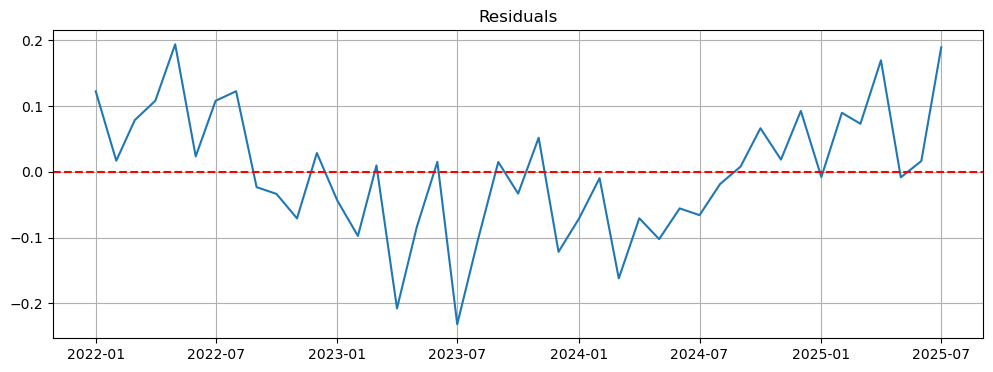

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson

# 1. 데이터 로드 및 전처리
df = pd.read_csv("open/train.csv") # 경로 확인 필요
df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))

# 2. Aggregation: Date 단위 Sum (Artifact 제거)
df_agg = df.groupby("date")["value"].sum().reset_index()
df_agg = df_agg.sort_values("date").set_index("date")

# 3. 로그 변환 (분산 안정화)
df_agg["log_value"] = np.log1p(df_agg["value"])

# (선택) 이상치 처리: Winsorization 예시 (하위 1%, 상위 99% clip)
# q01 = df_agg["log_value"].quantile(0.01)
# q99 = df_agg["log_value"].quantile(0.99)
# df_agg["log_value"] = df_agg["log_value"].clip(q01, q99)

# 4. 시각화: 변환된 시계열
plt.figure(figsize=(12, 5))
plt.plot(df_agg.index, df_agg["log_value"], label="Log(Value)")
plt.title("Log Transformed & Aggregated Time Series")
plt.grid(True)
plt.legend()
plt.show()

# 5. 시계열 진단 (ADF Test)
adf_result = adfuller(df_agg["log_value"])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] > 0.05:
    print(">> 시계열이 비정상(Non-stationary)입니다. 차분이나 추세 제거가 필요합니다.")
else:
    print(">> 시계열이 정상(Stationary)입니다.")

# 6. ACF / PACF 확인
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df_agg["log_value"], ax=ax[0], lags=20)
plot_pacf(df_agg["log_value"], ax=ax[1], lags=20)
plt.show()

# 7. 시계열 분해 (STL / Seasonal Decompose)
decomposition = seasonal_decompose(df_agg["log_value"], model='additive', period=12)
decomposition.plot()
plt.show()

# 8. 선형 모델링 (Trend + Seasonality)
df_agg["time_idx"] = np.arange(len(df_agg))
df_agg["month_str"] = df_agg.index.month.astype(str)

# 모델 적합
model = smf.ols("log_value ~ time_idx + C(month_str)", data=df_agg).fit()
print(model.summary())

# 잔차 진단 (Durbin-Watson)
dw = durbin_watson(model.resid)
print(f"\nDurbin-Watson Statistic: {dw:.4f}")
if dw < 1.5:
    print(">> 잔차에 양의 자기상관이 있습니다. AR 모델 추가를 고려하세요.")

# 잔차 시각화
plt.figure(figsize=(12, 4))
plt.plot(model.resid)
plt.title("Residuals")
plt.axhline(0, color='r', linestyle='--')
plt.grid(True)
plt.show()

Train 기간: 2022-01-01 00:00:00 ~ 2025-01-01 00:00:00
Test  기간: 2025-02-01 00:00:00 ~ 2025-07-01 00:00:00

>> 최적 파라미터(AIC) 탐색 중... (시간이 조금 걸릴 수 있습니다)
Best SARIMA Model: (1, 0, 1) x (0, 0, 0, 12)12
Best AIC: -49.0062

Test Set RMSE: 51178956.90


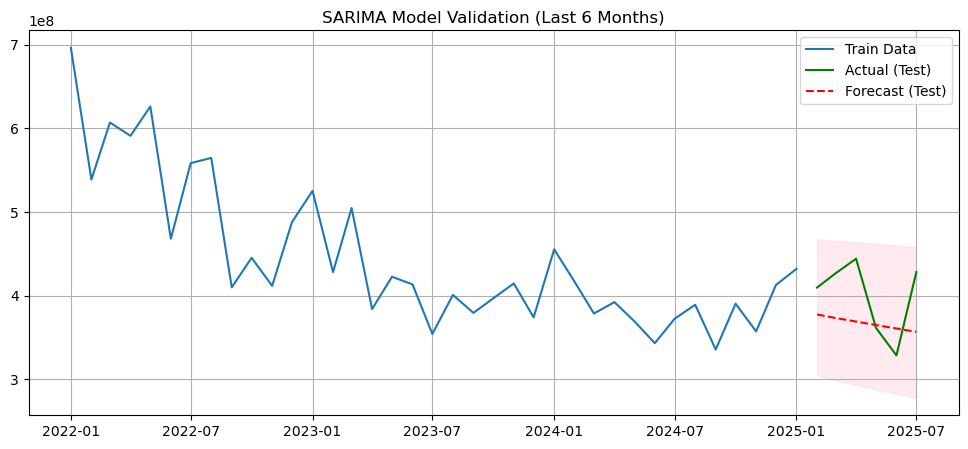

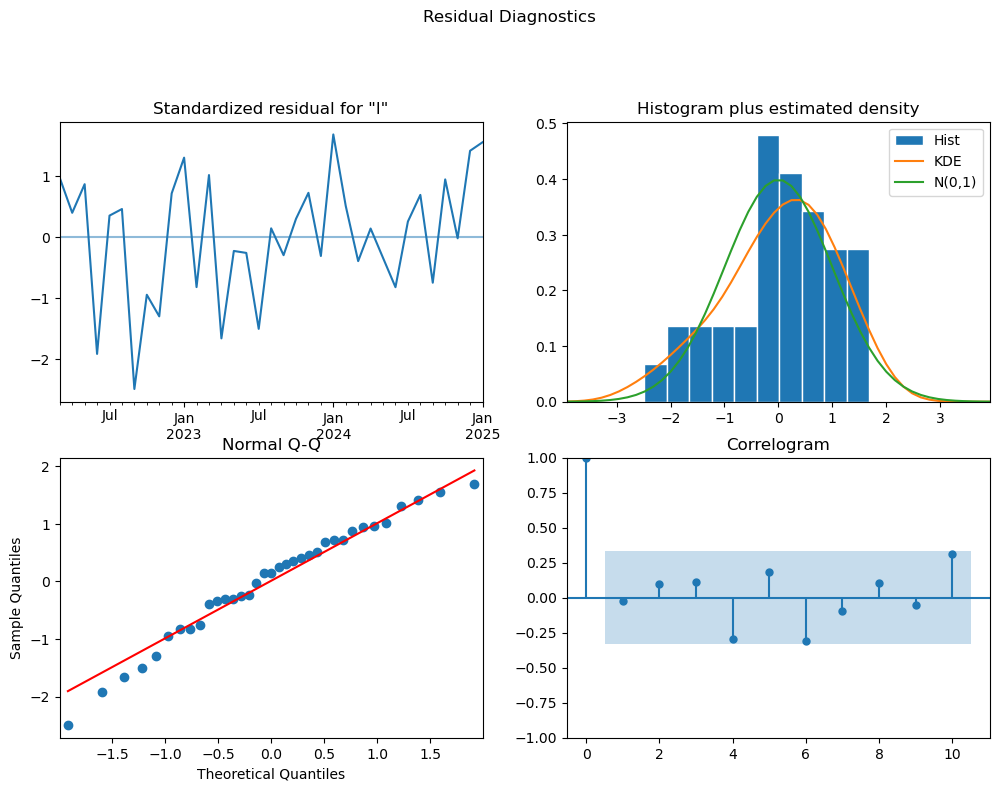


>> 향후 6개월 예측값 (상위 5개):
2025-08-01    3.797359e+08
2025-09-01    3.760693e+08
2025-10-01    3.724398e+08
2025-11-01    3.688471e+08
2025-12-01    3.652908e+08
2026-01-01    3.617705e+08
Freq: MS, Name: predicted_mean, dtype: float64


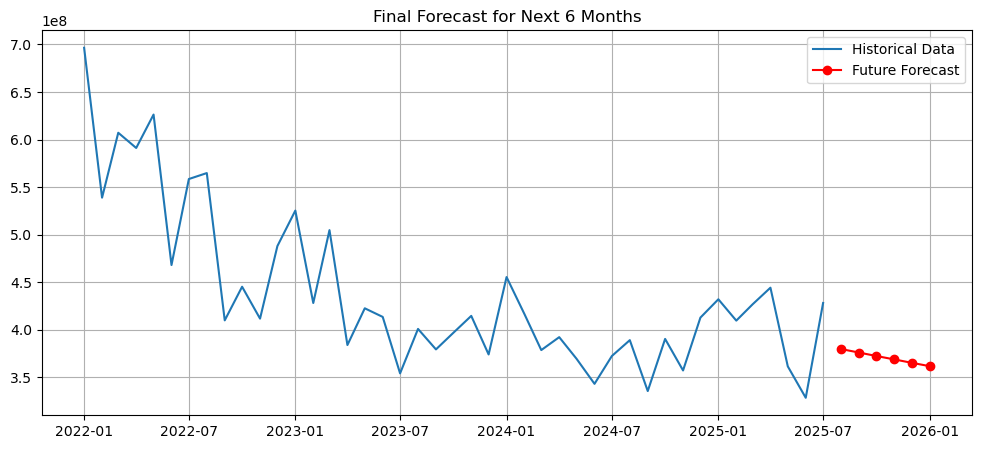

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import warnings

warnings.filterwarnings("ignore") # 경고 메시지 숨김

# ==========================================
# 1. 데이터 준비 (이전 단계와 동일)
# ==========================================
df = pd.read_csv("open/train.csv") # 파일 경로 확인
df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))

# Date 단위 집계 및 로그 변환
df_agg = df.groupby("date")["value"].sum().reset_index()
df_agg = df_agg.sort_values("date").set_index("date")
df_agg["log_value"] = np.log1p(df_agg["value"])

# Train / Test 분리 (마지막 6개월을 검증용으로 사용)
train_data = df_agg.iloc[:-6]
test_data = df_agg.iloc[-6:]

print(f"Train 기간: {train_data.index.min()} ~ {train_data.index.max()}")
print(f"Test  기간: {test_data.index.min()} ~ {test_data.index.max()}")

# ==========================================
# 2. 최적 파라미터 탐색 (Grid Search)
# ==========================================
print("\n>> 최적 파라미터(AIC) 탐색 중... (시간이 조금 걸릴 수 있습니다)")

# 파라미터 범위 설정 (너무 크면 오래 걸림)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

best_aic = float("inf")
best_param = None
best_seasonal_param = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(train_data["log_value"],
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_seasonal_param = seasonal_param
        except:
            continue

print(f"Best SARIMA Model: {best_param} x {best_seasonal_param}12")
print(f"Best AIC: {best_aic:.4f}")

# ==========================================
# 3. 최적 모델 학습 및 검증 (Test Set)
# ==========================================
# 전체 데이터(Train+Test)가 아닌 Train 데이터로 모델 학습
best_model = SARIMAX(train_data["log_value"],
                     order=best_param,
                     seasonal_order=best_seasonal_param,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
best_model_fit = best_model.fit(disp=False)

# Test 기간 예측
forecast_steps = len(test_data)
forecast = best_model_fit.get_forecast(steps=forecast_steps)
forecast_log = forecast.predicted_mean
conf_int_log = forecast.conf_int()

# 로그 역변환 (원래 스케일로 복구)
forecast_val = np.expm1(forecast_log)
test_val = np.expm1(test_data["log_value"])
conf_int_val = np.expm1(conf_int_log)

# 평가 (RMSE)
rmse = np.sqrt(mean_squared_error(test_val, forecast_val))
print(f"\nTest Set RMSE: {rmse:.2f}")

# 시각화 (검증)
plt.figure(figsize=(12, 5))
plt.plot(np.expm1(train_data["log_value"]), label="Train Data")
plt.plot(test_val.index, test_val, label="Actual (Test)", color='green')
plt.plot(test_val.index, forecast_val, label="Forecast (Test)", color='red', linestyle='--')
plt.fill_between(test_val.index, conf_int_val.iloc[:, 0], conf_int_val.iloc[:, 1], color='pink', alpha=0.3)
plt.title("SARIMA Model Validation (Last 6 Months)")
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 4. 잔차 진단 (Residual Diagnostics)
# ==========================================
best_model_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle("Residual Diagnostics", y=1.02)
plt.show()

# ==========================================
# 5. 최종 미래 예측 (Future Forecast)
# ==========================================
# 이제 전체 데이터로 재학습하여 미래를 예측
final_model = SARIMAX(df_agg["log_value"],
                      order=best_param,
                      seasonal_order=best_seasonal_param,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_fit = final_model.fit(disp=False)

# 향후 6개월 예측
future_steps = 6
future_forecast = final_fit.get_forecast(steps=future_steps)
future_log = future_forecast.predicted_mean
future_val = np.expm1(future_log)

print("\n>> 향후 6개월 예측값 (상위 5개):")
print(future_val)

# 최종 시각화
plt.figure(figsize=(12, 5))
plt.plot(np.expm1(df_agg["log_value"]), label="Historical Data")
plt.plot(future_val.index, future_val, label="Future Forecast", color='red', marker='o')
plt.title("Final Forecast for Next 6 Months")
plt.legend()
plt.grid(True)
plt.show()

12개월 주기의 반복 패턴이 없다라고 모델이 결론을 내림.

20:48:09 - cmdstanpy - INFO - Chain [1] start processing
20:48:12 - cmdstanpy - INFO - Chain [1] done processing


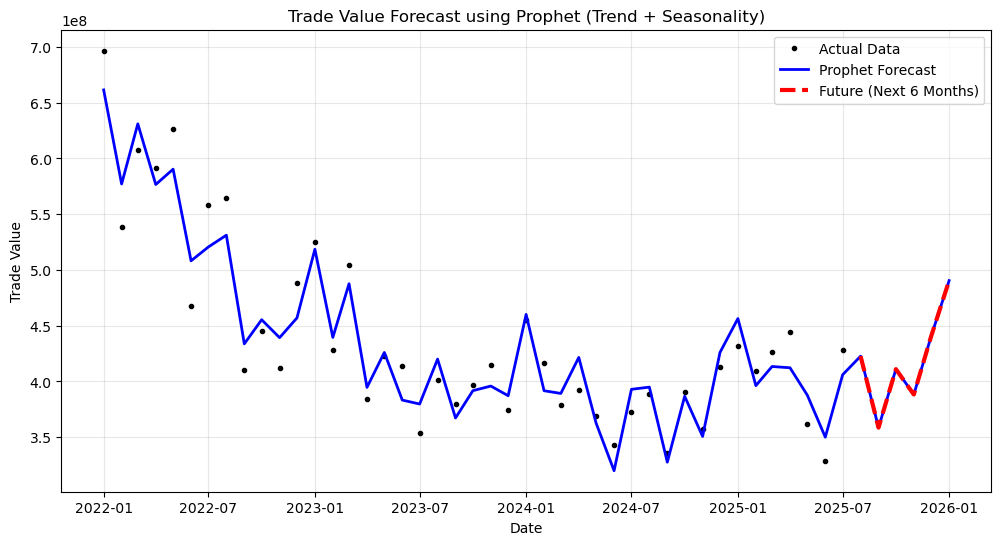

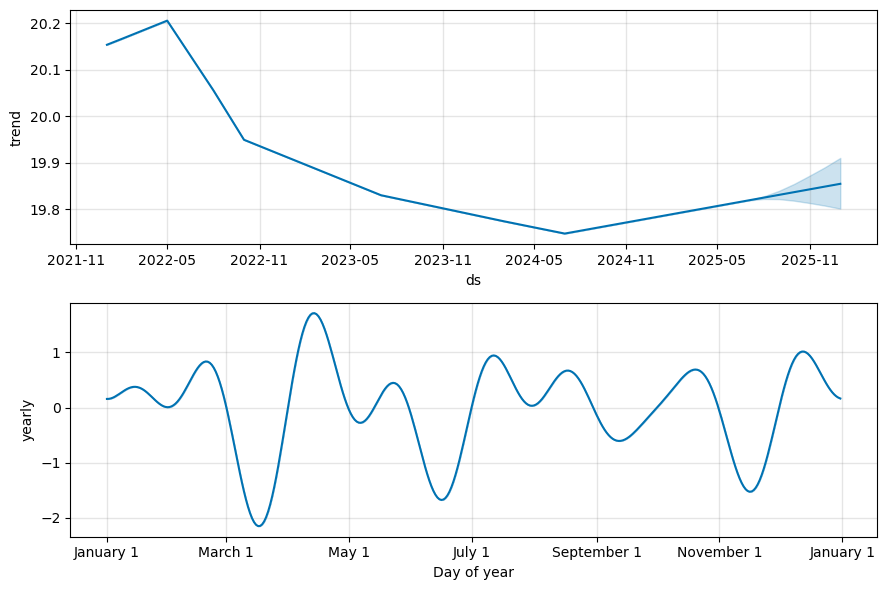

           ds  yhat_rescaled
43 2025-08-01   4.226892e+08
44 2025-09-01   3.585934e+08
45 2025-10-01   4.110176e+08
46 2025-11-01   3.883040e+08
47 2025-12-01   4.406181e+08
48 2026-01-01   4.904199e+08


In [9]:
# =========================================================
# Facebook Prophet 모델링
# (설치 필요: pip install prophet)
# =========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# 1. 데이터 준비 (Prophet은 컬럼명을 ds, y로 지정해야 함)
df = pd.read_csv("open/train.csv") # 파일 경로 확인
df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))

# 집계 및 로그 변환
df_agg = df.groupby("date")["value"].sum().reset_index()
df_prophet = df_agg.rename(columns={"date": "ds", "value": "y"})
df_prophet["y"] = np.log1p(df_prophet["y"]) # 로그 변환 유지

# 2. 모델 생성 및 학습
# changepoint_prior_scale: 트렌드 변화를 얼마나 민감하게 잡을지 (기본 0.05, 높이면 유연해짐)
# seasonality_mode: 'multiplicative'는 데이터 크기에 따라 계절성 폭도 커질 때 사용
model = Prophet(yearly_seasonality=True, 
                weekly_seasonality=False, 
                daily_seasonality=False,
                changepoint_prior_scale=0.1) 

model.fit(df_prophet)

# 3. 미래 날짜 생성 (향후 6개월)
future = model.make_future_dataframe(periods=6, freq='MS') # MS: Month Start

# 4. 예측 수행
forecast = model.predict(future)

# 5. 로그 역변환 (원래 값으로 복구)
forecast["yhat_rescaled"] = np.expm1(forecast["yhat"])
df_prophet["y_rescaled"] = np.expm1(df_prophet["y"])

# =========================================================
# 6. 시각화 (직관적 확인)
# =========================================================
plt.figure(figsize=(12, 6))

# 실제 데이터 (검은 점)
plt.plot(df_prophet["ds"], df_prophet["y_rescaled"], 'k.', label="Actual Data")

# 예측 데이터 (파란 선)
# 과거 데이터 구간 + 미래 예측 구간
plt.plot(forecast["ds"], forecast["yhat_rescaled"], 'b-', label="Prophet Forecast", linewidth=2)

# 미래 예측 구간 강조 (빨간 점선)
future_forecast = forecast.iloc[-6:]
plt.plot(future_forecast["ds"], future_forecast["yhat_rescaled"], 'r--', label="Future (Next 6 Months)", linewidth=3)

plt.title("Trade Value Forecast using Prophet (Trend + Seasonality)")
plt.xlabel("Date")
plt.ylabel("Trade Value")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# =========================================================
# 7. 구성 요소 분해 (트렌드 vs 계절성 확인)
# =========================================================
fig2 = model.plot_components(forecast)
plt.show()

# 예측값 출력
print(future_forecast[["ds", "yhat_rescaled"]].tail(6))

In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# =========================================================
# 1. 데이터 로드 및 전처리
# =========================================================
print(">> 1. 데이터 로드 및 전처리...")
train = pd.read_csv('open/train.csv')

# 날짜 생성 및 정렬
train["date"] = pd.to_datetime(dict(year=train.year, month=train.month, day=1))

# Pivot Table 생성 (행: 날짜, 열: item_id) -> 로그 변환
pivot = train.pivot_table(index="date", columns="item_id", values="value", fill_value=0)
pivot_log = np.log1p(pivot)

print(f"총 아이템 수: {len(pivot.columns)}")

# =========================================================
# 2. 전체 데이터에서 공행성 쌍(Pair) 자체 발굴
# =========================================================
print(">> 2. 전체 데이터에서 공행성 쌍(Pair) 발굴 중...")

def find_best_pairs(pivot_log, threshold=0.35, min_obs=12):
    # 속도를 위해 numpy 변환
    data_values = pivot_log.values
    items = pivot_log.columns
    n_months = len(pivot_log)
    
    pairs_list = []
    
    # ⚠️ 모든 조합(N*N)을 돌면 시간이 너무 오래 걸리므로, 
    # 실제로는 분산이 0이거나 거래량이 너무 적은 아이템은 제외하는 것이 좋습니다.
    # 여기서는 진행률(tqdm)을 보며 전체 탐색을 수행합니다.
    
    for i in tqdm(range(len(items)), desc="Leader 탐색"):
        leader_ts = data_values[:, i]
        
        # 거래 데이터가 너무 적으면 스킵 (최소 1년치 이상)
        if np.count_nonzero(leader_ts) < min_obs:
            continue
            
        for j in range(len(items)):
            if i == j: continue # 자기 자신 제외
            
            follower_ts = data_values[:, j]
            if np.count_nonzero(follower_ts) < min_obs:
                continue
            
            best_lag = -1
            max_corr = 0
            
            # Lag 1 ~ 6개월 탐색
            for lag in range(1, 7):
                # Leader(t-lag) vs Follower(t)
                # 상관계수 계산 (slice 주의)
                x = leader_ts[:-lag]
                y = follower_ts[lag:]
                
                # 값이 있는 구간만 계산 (safe correlation)
                if len(x) < min_obs: continue
                
                # 단순 corrcoef는 빠르지만 NaN 처리가 안되므로 pandas corr 권장
                # 여기서는 numpy로 빠르게 계산하되 0인 경우 제외 로직 간소화
                
                # (정확도를 위해 pandas corr 사용 - 속도는 느리지만 안전함)
                # 실제 대용량 데이터라면 numpy로 최적화 필요
                series_leader = pd.Series(x)
                series_follower = pd.Series(y)
                
                corr = series_leader.corr(series_follower)
                
                if not np.isnan(corr) and abs(corr) > abs(max_corr):
                    max_corr = corr
                    best_lag = lag
            
            # 임계값 넘는 쌍만 저장
            if abs(max_corr) >= threshold:
                pairs_list.append({
                    'leading_item_id': items[i],
                    'following_item_id': items[j],
                    'best_lag': best_lag,
                    'max_corr': max_corr
                })
                
    return pd.DataFrame(pairs_list)

# 임계값 0.35로 설정 (노이즈 제거 + 충분한 쌍 확보)
discovered_pairs = find_best_pairs(pivot_log, threshold=0.35)
print(f"발견된 공행성 쌍: {len(discovered_pairs)}개")

# =========================================================
# 3. 학습 데이터 생성 (Feature Engineering)
# =========================================================
print(">> 3. 학습 데이터 생성 중...")

def build_features(pivot_log, pair_stats, is_train=True):
    data_list = []
    last_date = pivot_log.index[-1] # 2025-07
    
    for i, row in tqdm(pair_stats.iterrows(), total=len(pair_stats)):
        leader = row['leading_item_id']
        follower = row['following_item_id']
        lag = int(row['best_lag'])
        corr = float(row['max_corr'])
        
        # 1. 학습용 데이터 (과거 이력 전체 사용)
        if is_train:
            tmp = pd.DataFrame({
                "y": pivot_log[follower], # Target (t)
                
                # Follower Features
                "b_t_1": pivot_log[follower].shift(1),
                "b_t_2": pivot_log[follower].shift(2),
                "b_ma3": pivot_log[follower].rolling(3).mean().shift(1),
                
                # Leader Features (Lag 적용)
                "a_t_lag": pivot_log[leader].shift(lag),
                "a_t_lag1": pivot_log[leader].shift(lag + 1),
                "a_ma3": pivot_log[leader].rolling(3).mean().shift(lag),
                "a_std3": pivot_log[leader].rolling(3).std().shift(lag), # 변동성 추가
                
                # Meta
                "max_corr": corr,
                "best_lag": lag,
                "month": pivot_log.index.month
            }).dropna()
            
            # 계절성 추가 (Cyclic)
            tmp["month_sin"] = np.sin(2 * np.pi * tmp["month"] / 12)
            tmp["month_cos"] = np.cos(2 * np.pi * tmp["month"] / 12)
            
            data_list.append(tmp)
            
        # 2. 예측용 데이터 (2025년 8월 예측용 Input 1행 생성)
        else:
            # 8월 기준 예측
            target_month = 8
            
            # Leader의 Lag 시점 계산
            # 예: lag=1이면 2025-07 데이터 사용, lag=2면 2025-06 데이터 사용
            lag_date_idx = len(pivot_log) - lag
            if lag_date_idx < 0: lag_date_idx = 0 # 예외처리
            
            # Leader 값 가져오기 (iloc 사용)
            leader_series = pivot_log[leader]
            a_t_lag = leader_series.iloc[lag_date_idx]
            a_t_lag1 = leader_series.iloc[lag_date_idx - 1] if lag_date_idx > 0 else 0
            
            # Rolling window 계산 (직전 3개월)
            a_ma3 = leader_series.iloc[lag_date_idx-2 : lag_date_idx+1].mean()
            a_std3 = leader_series.iloc[lag_date_idx-2 : lag_date_idx+1].std()

            # Follower 값 가져오기 (2025-07 기준)
            follower_series = pivot_log[follower]
            b_t_1 = follower_series.iloc[-1]
            b_t_2 = follower_series.iloc[-2]
            b_ma3 = follower_series.iloc[-3:].mean()
            
            feat = {
                'leading_item_id': leader,
                'following_item_id': follower,
                'b_t_1': b_t_1,
                'b_t_2': b_t_2,
                'b_ma3': b_ma3,
                'a_t_lag': a_t_lag,
                'a_t_lag1': a_t_lag1,
                'a_ma3': a_ma3,
                'a_std3': a_std3,
                'max_corr': corr,
                'best_lag': lag,
                'month_sin': np.sin(2 * np.pi * target_month / 12),
                'month_cos': np.cos(2 * np.pi * target_month / 12)
            }
            data_list.append(feat)

    if is_train:
        return pd.concat(data_list, ignore_index=True)
    else:
        return pd.DataFrame(data_list)

# 학습 데이터 생성
df_train = build_features(pivot_log, discovered_pairs, is_train=True)

# =========================================================
# 4. 모델 학습 (XGBoost - Slow Learning)
# =========================================================
print(">> 4. XGBoost 모델 학습 중...")

features = [
    'b_t_1', 'b_t_2', 'b_ma3', 
    'a_t_lag', 'a_t_lag1', 'a_ma3', 'a_std3', 
    'max_corr', 'best_lag', 'month_sin', 'month_cos'
]

X = df_train[features]
y = df_train['y']

# Train/Valid 분리 (성능 모니터링용)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

model = xgb.XGBRegressor(
    n_estimators=10000,      # 충분한 학습량
    learning_rate=0.05,     # 정밀한 학습
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=100
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# =========================================================
# 5. 예측 및 결과 파일 생성
# =========================================================
print(">> 5. 최종 예측 및 CSV 생성 중...")

# 예측용 데이터 생성
df_test = build_features(pivot_log, discovered_pairs, is_train=False)
df_test = df_test.fillna(0) # 결측치 처리

# 예측 수행
preds_log = model.predict(df_test[features])
preds_val = np.expm1(preds_log) # 로그 역변환

# 결과 DataFrame 생성
final_submission = pd.DataFrame({
    'leading_item_id': df_test['leading_item_id'],
    'following_item_id': df_test['following_item_id'],
    'value': preds_val
})

# 음수 제거 및 정수 변환
final_submission['value'] = final_submission['value'].apply(lambda x: max(0, int(round(x))))

# 저장
final_submission.to_csv("mu_11_25_2nd.csv", index=False)
print(">> 'mu_11_25_2nd.csv' 생성 완료!")
print(f"총 {len(final_submission)}개의 공행성 쌍을 발굴하여 예측했습니다.")
print(final_submission.head())

>> 1. 데이터 로드 및 전처리...
총 아이템 수: 100
>> 2. 전체 데이터에서 공행성 쌍(Pair) 발굴 중...


Leader 탐색: 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


발견된 공행성 쌍: 2057개
>> 3. 학습 데이터 생성 중...


100%|██████████| 2057/2057 [00:02<00:00, 904.21it/s]


>> 4. XGBoost 모델 학습 중...
[0]	validation_0-rmse:3.20780
[100]	validation_0-rmse:1.24862
[200]	validation_0-rmse:1.04660
[300]	validation_0-rmse:0.89518
[400]	validation_0-rmse:0.79153
[500]	validation_0-rmse:0.72526
[600]	validation_0-rmse:0.66939
[700]	validation_0-rmse:0.62397
[800]	validation_0-rmse:0.58378
[900]	validation_0-rmse:0.55846
[1000]	validation_0-rmse:0.53213
[1100]	validation_0-rmse:0.51355
[1200]	validation_0-rmse:0.49607
[1300]	validation_0-rmse:0.47939
[1400]	validation_0-rmse:0.46734
[1500]	validation_0-rmse:0.45531
[1600]	validation_0-rmse:0.44576
[1700]	validation_0-rmse:0.43720
[1800]	validation_0-rmse:0.43028
[1900]	validation_0-rmse:0.42282
[2000]	validation_0-rmse:0.41523
[2100]	validation_0-rmse:0.40947
[2200]	validation_0-rmse:0.40439
[2300]	validation_0-rmse:0.39984
[2400]	validation_0-rmse:0.39525
[2500]	validation_0-rmse:0.39128
[2600]	validation_0-rmse:0.38826
[2700]	validation_0-rmse:0.38471
[2800]	validation_0-rmse:0.38131
[2900]	validation_0-rmse:0.378

100%|██████████| 2057/2057 [00:00<00:00, 7112.04it/s]


>> 'mu_11_25_2nd.csv' 생성 완료!
총 2057개의 공행성 쌍을 발굴하여 예측했습니다.
  leading_item_id following_item_id    value
0        AANGBULD          APQGTRMF      996
1        AANGBULD          AXULOHBQ    36073
2        AANGBULD          BEZYMBBT  1215755
3        AANGBULD          BLANHGYY      825
4        AANGBULD          BSRMSVTC    78398


In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# =========================================================
# 1. 데이터 로드 및 기본 전처리
# =========================================================
df = pd.read_csv("open/train.csv")
df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))

# Pivot: 행(날짜) x 열(아이템ID)
pivot_df = df.pivot_table(index="date", columns="item_id", values="value", fill_value=0)
pivot_df_log = np.log1p(pivot_df) # 로그 변환

# =========================================================
# 2. 공행성 쌍(Pair) 추출 (조건 강화)
# =========================================================
print(">> 공행성 쌍 탐색 중 (조건 강화)...")

# 상관계수 계산 (Lag 1개월 기준)
shifted_df = pivot_df_log.shift(1).iloc[1:] # t-1
current_df = pivot_df_log.iloc[1:]          # t

# 상위 500개 우량 아이템 위주로 먼저 탐색 (속도 및 퀄리티 확보)
top_items = pivot_df.sum().sort_values(ascending=False).head(500).index
target_df = current_df[top_items]
source_df = shifted_df[top_items]

# 상관계수 계산
corr_matrix = source_df.apply(lambda x: target_df.corrwith(x))
stacked_corr = corr_matrix.stack()

# ✅ 수정 포인트: 임계값 0.30 -> 0.33로 상향 (노이즈 제거)
# 자기 자신 제외
strong_pairs = stacked_corr[(stacked_corr > 0.30) & (stacked_corr.index.get_level_values(0) != stacked_corr.index.get_level_values(1))]

# 상위 2,500개만 선택 (Best Pairs)
strong_pairs = strong_pairs.sort_values(ascending=False).head(2500)
print(f"선택된 공행성 쌍: {len(strong_pairs)}개")

# =========================================================
# 3. 데이터셋 생성 (피처 엔지니어링 강화)
# =========================================================
data_list = []

print(">> 학습 데이터셋 생성 중...")
for (leader, follower), corr_score in tqdm(strong_pairs.items()):
    
    # 기본 데이터 프레임
    tmp = pd.DataFrame({
        "target": pivot_df_log[follower],             # y: 후행(t)
        
        # [기존 피처]
        "b_t_1": pivot_df_log[follower].shift(1),     # 후행(t-1)
        "b_t_2": pivot_df_log[follower].shift(2),     # 후행(t-2)
        "b_ma3": pivot_df_log[follower].rolling(3).mean().shift(1), # 후행 이동평균
        
        "a_t_lag1": pivot_df_log[leader].shift(1),    # 선행(t-1)
        "a_t_lag2": pivot_df_log[leader].shift(2),    # 선행(t-2)
        "a_ma3": pivot_df_log[leader].rolling(3).mean().shift(1), # 선행 이동평균
        
        # [✅ 추가된 피처: 변동성]
        "a_std3": pivot_df_log[leader].rolling(3).std().shift(1), # 선행 표준편차(변동성)
        
        # 메타 정보
        "max_corr": corr_score,                       # 관계 강도
        "month": pivot_df_log.index.month             # 월 정보
    }).dropna()
    
    # [✅ 추가된 피처: 계절성 Cyclic Encoding]
    # 12월과 1월이 멀지 않음을 수치적으로 표현
    tmp["month_sin"] = np.sin(2 * np.pi * tmp["month"] / 12)
    tmp["month_cos"] = np.cos(2 * np.pi * tmp["month"] / 12)
    
    # 식별자 추가
    tmp["leader_id"] = leader
    tmp["follower_id"] = follower
    
    data_list.append(tmp)

full_data = pd.concat(data_list)

# 학습용 변수 설정
features = [
    "b_t_1", "b_t_2", "b_ma3", 
    "a_t_lag1", "a_t_lag2", "a_ma3", "a_std3",
    "max_corr", "month_sin", "month_cos"
]

X = full_data[features]
y = full_data["target"]

# Train / Valid 분리 (검증을 위해)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# =========================================================
# 4. XGBoost 모델링 (파라미터 튜닝)
# =========================================================
print(">> XGBoost 학습 시작 (Slow Learning)...")

# ✅ 수정 포인트: 하이퍼파라미터 튜닝
# n_estimators를 늘리고 learning_rate를 줄여서 정밀도 향상
model = xgb.XGBRegressor(
    n_estimators=2000,      # 기존 150 -> 1000 (충분히 학습)
    learning_rate=0.01,     # 기존 0.08 -> 0.02 (천천히 학습)
    max_depth=6,            # 깊이 약간 증가 (복잡한 패턴 수용)
    subsample=0.8,          # 데이터 샘플링 (과적합 방지)
    colsample_bytree=0.8,   # 피처 샘플링 (과적합 방지)
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # 더 이상 좋아지지 않으면 멈춤
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# =========================================================
# 5. 2025년 8월 예측 및 제출 파일 생성
# =========================================================
print(">> 최종 예측 수행 중...")

results = []
target_month = 8

# 마지막 시점 데이터 (2025-07) 가져오기
last_idx = "2025-07-01"

for (leader, follower), corr_score in strong_pairs.items():
    
    # 입력 데이터 생성 (1행)
    input_row = pd.DataFrame([{
        "b_t_1": pivot_df_log.loc[last_idx, follower],
        "b_t_2": pivot_df_log.shift(1).loc[last_idx, follower],
        "b_ma3": pivot_df_log[follower].rolling(3).mean().loc[last_idx],
        
        "a_t_lag1": pivot_df_log.loc[last_idx, leader],
        "a_t_lag2": pivot_df_log.shift(1).loc[last_idx, leader],
        "a_ma3": pivot_df_log[leader].rolling(3).mean().loc[last_idx],
        "a_std3": pivot_df_log[leader].rolling(3).std().loc[last_idx],
        
        "max_corr": corr_score,
        "month_sin": np.sin(2 * np.pi * target_month / 12),
        "month_cos": np.cos(2 * np.pi * target_month / 12)
    }])
    
    # 예측
    pred_log = model.predict(input_row[features])[0]
    pred_val = np.expm1(pred_log) # 로그 역변환
    
    results.append({
        "leading_item_id": leader,
        "following_item_id": follower,
        "value": int(pred_val)
    })

submission = pd.DataFrame(results)
submission.to_csv("mu_11_25_1st.csv", index=False)

print("\n✅ sample_submission_tuned.csv 생성 완료!")
print(f"모델 Best Score (RMSE log scale): {model.best_score:.4f}")

>> 공행성 쌍 탐색 중 (조건 강화)...
선택된 공행성 쌍: 619개
>> 학습 데이터셋 생성 중...


619it [00:00, 830.35it/s]

>> XGBoost 학습 시작 (Slow Learning)...
[0]	validation_0-rmse:4.08873


[100]	validation_0-rmse:2.04713
[200]	validation_0-rmse:1.51145
[300]	validation_0-rmse:1.36463
[400]	validation_0-rmse:1.30030
[500]	validation_0-rmse:1.25738
[600]	validation_0-rmse:1.22455
[700]	validation_0-rmse:1.19717
[800]	validation_0-rmse:1.17788
[900]	validation_0-rmse:1.15780
[1000]	validation_0-rmse:1.14155
[1100]	validation_0-rmse:1.12582
[1200]	validation_0-rmse:1.11298
[1300]	validation_0-rmse:1.10140
[1400]	validation_0-rmse:1.09069
[1500]	validation_0-rmse:1.08092
[1600]	validation_0-rmse:1.07115
[1700]	validation_0-rmse:1.06307
[1800]	validation_0-rmse:1.05496
[1900]	validation_0-rmse:1.04868
[1999]	validation_0-rmse:1.04218
>> 최종 예측 수행 중...

✅ sample_submission_tuned.csv 생성 완료!
모델 Best Score (RMSE log scale): 1.0422


100it [00:01, 66.86it/s]
/var/folders/38/3vzxy55538v2l9xwy49ftsb00000gn/T/ipykernel_3860/2365582373.py:110: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  seasonal_index = pivot_with_month.groupby(pivot_with_month.columns.month, axis=1).mean()


📌 Validation Evaluation
RMSE : 3,315,679.345
MAE  : 1,237,313.079
R²   : 0.9233
MAPE : 1055160.91%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


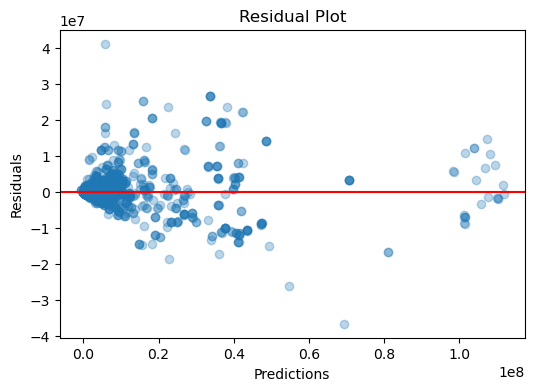

0it [00:00, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# -------------------------
# 1. 데이터 로드 및 피벗
# -------------------------
train = pd.read_csv('open/train.csv')

monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)


# -------------------------
# 2. 상관계수 계산 함수
# -------------------------
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])


# -------------------------
# 3. 공행성 쌍 탐색
# -------------------------
def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue
            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                corr = safe_corr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    return pd.DataFrame(results)


pairs = find_comovement_pairs(pivot)


# -------------------------
# 4. 월별 seasonality 계산
# -------------------------
monthly['month_str'] = monthly['month'].astype(str)
seasonal_table = (
    monthly.groupby(['item_id', 'month'])['value']
    .mean()
    .unstack(fill_value=0)
)


# -------------------------
# 5. 확장된 FE 기반 학습 데이터 생성
# -------------------------
def build_training_data_fe(pivot, pairs):
    months = pivot.columns.to_list()
    n_months = len(months)
    

    pivot_with_month = pivot.copy()
    pivot_with_month.columns = pd.to_datetime(pivot_with_month.columns)
    
    seasonal_index = pivot_with_month.groupby(pivot_with_month.columns.month, axis=1).mean()

    rows = []
    
    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        
        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)
        
        b_df = pd.DataFrame({"b": b_series})

        b_df["roll_mean_3"] = b_df["b"].rolling(3).mean()
        b_df["roll_mean_5"] = b_df["b"].rolling(5).mean()
        b_df["roll_mean_7"] = b_df["b"].rolling(7).mean()
        b_df["roll_mean_12"] = b_df["b"].rolling(12).mean()
        
        b_df["roll_std_3"] = b_df["b"].rolling(3).std()
        b_df["roll_std_5"] = b_df["b"].rolling(5).std()
        b_df["roll_std_12"] = b_df["b"].rolling(12).std()
        
        b_df["trend"] = b_df["b"] - b_df["b"].shift(1)
        
        b_df["month"] = pivot_with_month.columns.month
        b_df["season_index"] = b_df["month"].apply(
            lambda m: seasonal_index.loc[follower, m] if follower in seasonal_index.index else 0
        )
        
        for t in range(max(lag, 12), n_months - 1):
            b_t = b_series[t]
            b_t_1 = b_series[t - 1]
            a_t_lag = a_series[t - lag]
            target = b_series[t + 1]
            
            rows.append({
                "b_t": b_t,
                "b_t_1": b_t_1,
                "a_t_lag": a_t_lag,
                "max_corr": corr,
                "best_lag": float(lag),

                "roll_mean_3": b_df.loc[t, "roll_mean_3"],
                "roll_mean_5": b_df.loc[t, "roll_mean_5"],
                "roll_mean_7": b_df.loc[t, "roll_mean_7"],
                "roll_mean_12": b_df.loc[t, "roll_mean_12"],
                
                "roll_std_3": b_df.loc[t, "roll_std_3"],
                "roll_std_5": b_df.loc[t, "roll_std_5"],
                "roll_std_12": b_df.loc[t, "roll_std_12"],

                "trend": b_df.loc[t, "trend"],
                "season_index": b_df.loc[t, "season_index"],
                
                "target": target,
            })

    df = pd.DataFrame(rows).dropna()
    return df


# -------------------------
# 6. Linear Regression 학습 + Feature Scaling
# -------------------------
df_train_fe = build_training_data_fe(pivot, pairs)

feature_cols = [
    'b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag',
    'roll_mean_3','roll_mean_5','roll_mean_7','roll_mean_12',
    'roll_std_3','roll_std_5','roll_std_12',
    'trend','season_index'
]

X = df_train_fe[feature_cols]
y = df_train_fe["target"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.085, random_state=42
)

# ===== Feature Scaling =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = LinearRegression()
model.fit(X_train_scaled, y_train)


# -------------------------
# 7. 모델 평가 함수
# -------------------------
def evaluate_model(model, X_val, y_val):
    pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, pred, squared=False)
    mae = mean_absolute_error(y_val, pred)
    r2 = r2_score(y_val, pred)
    mape = np.mean(np.abs((y_val - pred) / np.maximum(y_val, 1))) * 100
    
    print("📌 Validation Evaluation")
    print(f"RMSE : {rmse:,.3f}")
    print(f"MAE  : {mae:,.3f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")

    plt.figure(figsize=(6,4))
    plt.scatter(pred, y_val - pred, alpha=0.3)
    plt.axhline(0, color='red')
    plt.title("Residual Plot")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.show()

evaluate_model(model, X_val_scaled, y_val)


# -------------------------
# 8. 예측 (스케일러 포함)
# -------------------------
def predict(pivot, pairs, model, scaler):
    months = pivot.columns.to_list()
    n_months = len(months)
    t_last = n_months - 1
    t_prev = n_months - 2
    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        if t_last - lag < 0:
            continue

        b_ts = pd.Series(b_series)
        b_ma3 = b_ts.rolling(3).mean().values
        b_ma5 = b_ts.rolling(5).mean().values
        b_ma7 = b_ts.rolling(7).mean().values
        b_ma12 = b_ts.rolling(12).mean().values
        b_std3 = b_ts.rolling(3).std().values
        b_std5 = b_ts.rolling(5).std().values
        b_std12 = b_ts.rolling(12).std().values

        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        last_trend = b_t - b_t_1
        month_idx = months[t_last].month
        seasonal_idx = seasonal_table.loc[follower, month_idx]

        X_test = np.array([[
            b_t, b_t_1, a_t_lag, corr, float(lag),
            b_ma3[t_last], b_ma5[t_last], b_ma7[t_last], b_ma12[t_last],
            b_std3[t_last], b_std5[t_last], b_std12[t_last],
            last_trend, seasonal_idx
        ]])

        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled)[0]
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred
        })

    return pd.DataFrame(preds)


submission = predict(pivot, pairs, model, scaler)
submission.to_csv('mu_11_25_3rd.csv', index=False)


위는 그냥 value로 공행성쌍 구하기.
아래는 value/weight로 공행성쌍 구함.

100it [00:01, 65.62it/s]


📌 Validation Evaluation
RMSE : 661.742
MAE  : 184.345
R²   : 0.5916
MAPE : 2065.11%


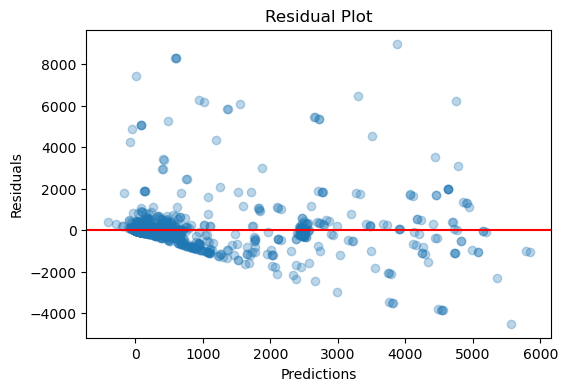

1280it [00:00, 3448.77it/s]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# -------------------------
# 1. 데이터 로드 및 피벗
# -------------------------
train = pd.read_csv('open/train.csv')

# 단위가치 = value / weight (weight==0 방지)
train["value_per_weight"] = train.apply(
    lambda row: row["value"] / row["weight"] if row["weight"] != 0 else 0, axis=1
)

monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)[["value", "value_per_weight"]]
    .sum()
)

monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value_per_weight")
    .fillna(0.0)
)


# -------------------------
# 2. 상관계수 계산 함수
# -------------------------
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])


# -------------------------
# 3. 공행성 쌍 탐색 (value_per_weight 기반)
# -------------------------
def find_comovement_pairs(pivot, max_lag=6, min_nonzero=12, corr_threshold=0.4):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    for i, leader in tqdm(enumerate(items)):
        x = pivot.loc[leader].values.astype(float)

        # 비영(0) 값이 너무 적으면 제외
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0

            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue

                # leader(t) → follower(t + lag)
                corr = safe_corr(x[:-lag], y[lag:])

                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag

            if best_lag is not None and abs(best_corr) >= corr_threshold:
                results.append({
                    "leading_item_id": leader,
                    "following_item_id": follower,
                    "best_lag": best_lag,
                    "max_corr": best_corr,
                })

    return pd.DataFrame(results)


pairs = find_comovement_pairs(pivot)



# -------------------------
# 4. 월별 seasonality 계산
# -------------------------
monthly['month_str'] = monthly['month'].astype(str)
seasonal_table = (
    monthly.groupby(['item_id', 'month'])['value']
    .mean()
    .unstack(fill_value=0)
)


# -------------------------
# 5. 확장된 FE 기반 학습 데이터 생성
# -------------------------
def build_training_data_fe(pivot, pairs):
    months = pivot.columns.to_list()
    n_months = len(months)

    pivot_with_month = pivot.copy()
    pivot_with_month.columns = pd.to_datetime(pivot_with_month.columns)

    seasonal_index = pivot_with_month.groupby(pivot_with_month.columns.month, axis=1).mean()

    rows = []

    for row in pairs.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        b_df = pd.DataFrame({"b": b_series})

        # Rolling Features
        b_df["roll_mean_3"] = b_df["b"].rolling(3).mean()
        b_df["roll_mean_5"] = b_df["b"].rolling(5).mean()
        b_df["roll_mean_7"] = b_df["b"].rolling(7).mean()
        b_df["roll_mean_12"] = b_df["b"].rolling(12).mean()

        b_df["roll_std_3"] = b_df["b"].rolling(3).std()
        b_df["roll_std_5"] = b_df["b"].rolling(5).std()
        b_df["roll_std_12"] = b_df["b"].rolling(12).std()

        b_df["trend"] = b_df["b"] - b_df["b"].shift(1)

        b_df["month"] = pivot_with_month.columns.month
        b_df["season_index"] = b_df["month"].apply(
            lambda m: seasonal_index.loc[follower, m] if follower in seasonal_index.index else 0
        )

        # Target 생성
        for t in range(max(lag, 12), n_months - 1):
            rows.append({
                "b_t": b_series[t],
                "b_t_1": b_series[t - 1],
                "a_t_lag": a_series[t - lag],
                "max_corr": corr,
                "best_lag": float(lag),

                "roll_mean_3": b_df.loc[t, "roll_mean_3"],
                "roll_mean_5": b_df.loc[t, "roll_mean_5"],
                "roll_mean_7": b_df.loc[t, "roll_mean_7"],
                "roll_mean_12": b_df.loc[t, "roll_mean_12"],

                "roll_std_3": b_df.loc[t, "roll_std_3"],
                "roll_std_5": b_df.loc[t, "roll_std_5"],
                "roll_std_12": b_df.loc[t, "roll_std_12"],

                "trend": b_df.loc[t, "trend"],
                "season_index": b_df.loc[t, "season_index"],

                "target": b_series[t + 1],
            })

    df = pd.DataFrame(rows).dropna()
    return df


# -------------------------
# 6. Feature Scaling + Linear Regression 학습
# -------------------------
df_train_fe = build_training_data_fe(pivot, pairs)

feature_cols = [
    'b_t', 'b_t_1', 'a_t_lag', 'max_corr', 'best_lag',
    'roll_mean_3','roll_mean_5','roll_mean_7','roll_mean_12',
    'roll_std_3','roll_std_5','roll_std_12',
    'trend','season_index'
]

X = df_train_fe[feature_cols]
y = df_train_fe["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.085, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = LinearRegression()
model.fit(X_train_scaled, y_train)


# -------------------------
# 7. 모델 평가
# -------------------------
def evaluate_model(model, X_val, y_val):
    pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, pred, squared=False)
    mae = mean_absolute_error(y_val, pred)
    r2 = r2_score(y_val, pred)
    mape = np.mean(np.abs((y_val - pred) / np.maximum(y_val, 1))) * 100
    
    print("📌 Validation Evaluation")
    print(f"RMSE : {rmse:,.3f}")
    print(f"MAE  : {mae:,.3f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")

    plt.figure(figsize=(6,4))
    plt.scatter(pred, y_val - pred, alpha=0.3)
    plt.axhline(0, color='red')
    plt.title("Residual Plot")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.show()


evaluate_model(model, X_val_scaled, y_val)


# -------------------------
# 8. 예측 함수
# -------------------------
def predict(pivot, pairs, model, scaler):
    months = pivot.columns.to_list()
    n_months = len(months)

    t_last = n_months - 1
    t_prev = n_months - 2

    preds = []

    for row in tqdm(pairs.itertuples(index=False)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        a_series = pivot.loc[leader].values.astype(float)
        b_series = pivot.loc[follower].values.astype(float)

        if t_last - lag < 0:
            continue

        # Rolling 계산
        b_ts = pd.Series(b_series)
        b_ma3 = b_ts.rolling(3).mean().values
        b_ma5 = b_ts.rolling(5).mean().values
        b_ma7 = b_ts.rolling(7).mean().values
        b_ma12 = b_ts.rolling(12).mean().values

        b_std3 = b_ts.rolling(3).std().values
        b_std5 = b_ts.rolling(5).std().values
        b_std12 = b_ts.rolling(12).std().values

        # Feature
        b_t = b_series[t_last]
        b_t_1 = b_series[t_prev]
        a_t_lag = a_series[t_last - lag]

        last_trend = b_t - b_t_1
        month_idx = months[t_last].month
        seasonal_idx = seasonal_table.loc[follower, month_idx]

        X_test = np.array([[
            b_t, b_t_1, a_t_lag, corr, float(lag),
            b_ma3[t_last], b_ma5[t_last], b_ma7[t_last], b_ma12[t_last],
            b_std3[t_last], b_std5[t_last], b_std12[t_last],
            last_trend, seasonal_idx
        ]])

        X_test_scaled = scaler.transform(X_test)
        y_pred = model.predict(X_test_scaled)[0]
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred
        })

    return pd.DataFrame(preds)


submission = predict(pivot, pairs, model, scaler)
submission.to_csv('mu_11_26_1st.csv', index=False)


score = 0.344

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBClassifier

train = pd.read_csv("open/train.csv")

monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" +
    monthly["month"].astype(str).str.zfill(2)
)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def extract_pair_features(pivot, max_lag=6, min_nonzero=12):
    items = pivot.index.to_list()
    n_months = pivot.shape[1]
    rows = []

    for leader in tqdm(items, desc="Extract pair features"):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if leader == follower:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            corrs = []
            best_corr, best_lag = 0.0, 0

            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                c = safe_corr(x[:-lag], y[lag:])
                corrs.append(abs(c))
                if abs(c) > abs(best_corr):
                    best_corr = c
                    best_lag = lag

            rows.append({
                "leader": leader,
                "follower": follower,
                "max_corr": best_corr,
                "best_lag": best_lag,
                "mean_abs_corr": np.mean(corrs),
                "std_abs_corr": np.std(corrs),
                "nonzero_ratio_a": np.count_nonzero(x) / len(x),
                "nonzero_ratio_b": np.count_nonzero(y) / len(y),
                "var_ratio": np.var(y) / (np.var(x) + 1e-6),
            })

    return pd.DataFrame(rows).dropna()

pair_df = extract_pair_features(pivot)

# pseudo-label (약한 규칙)
pair_df["label"] = (
    (pair_df["max_corr"].abs() >= 0.35) &
    (pair_df["best_lag"] > 0)
).astype(int)

clf_features = [
    "max_corr", "best_lag",
    "mean_abs_corr", "std_abs_corr",
    "nonzero_ratio_a", "nonzero_ratio_b",
    "var_ratio"
]

X = pair_df[clf_features]
y = pair_df["label"]

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

clf.fit(X_tr, y_tr)

pair_df["comove_prob"] = clf.predict_proba(X)[:, 1]
pairs_ml = (
    pair_df[pair_df["comove_prob"] >= 0.6]
    .rename(columns={
        "leader": "leading_item_id",
        "follower": "following_item_id"
    })[["leading_item_id", "following_item_id", "best_lag", "max_corr"]]
)

seasonal_table = (
    monthly.groupby(["item_id", "month"])["value"]
    .mean()
    .unstack(fill_value=0)
)

def build_training_data_fe(pivot, pairs_ml):
    months = pivot.columns.to_list()
    n_months = len(months)

    pivot_with_month = pivot.copy()
    pivot_with_month.columns = pd.to_datetime(pivot_with_month.columns)
    seasonal_index = pivot_with_month.groupby(
        pivot_with_month.columns.month, axis=1
    ).mean()

    rows = []

    for row in tqdm(pairs_ml.itertuples(index=False), desc="Build regression data"):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        a = pivot.loc[leader].values
        b = pivot.loc[follower].values

        b_df = pd.DataFrame({"b": b})
        for w in [3,5,7,12]:
            b_df[f"roll_mean_{w}"] = b_df["b"].rolling(w).mean()
        for w in [3,5,12]:
            b_df[f"roll_std_{w}"] = b_df["b"].rolling(w).std()

        b_df["trend"] = b_df["b"].diff()
        b_df["month"] = pivot_with_month.columns.month
        b_df["season_index"] = b_df["month"].apply(
            lambda m: seasonal_index.loc[follower, m]
        )

        for t in range(max(lag, 12), n_months - 1):
            rows.append({
                "b_t": b[t],
                "b_t_1": b[t-1],
                "a_t_lag": a[t-lag],
                "max_corr": corr,
                "best_lag": lag,
                "roll_mean_3": b_df.loc[t,"roll_mean_3"],
                "roll_mean_5": b_df.loc[t,"roll_mean_5"],
                "roll_mean_7": b_df.loc[t,"roll_mean_7"],
                "roll_mean_12": b_df.loc[t,"roll_mean_12"],
                "roll_std_3": b_df.loc[t,"roll_std_3"],
                "roll_std_5": b_df.loc[t,"roll_std_5"],
                "roll_std_12": b_df.loc[t,"roll_std_12"],
                "trend": b_df.loc[t,"trend"],
                "season_index": b_df.loc[t,"season_index"],
                "target": b[t+1],
            })

    return pd.DataFrame(rows).dropna()

df_train = build_training_data_fe(pivot, pairs_ml)

feature_cols = [
    'b_t','b_t_1','a_t_lag','max_corr','best_lag',
    'roll_mean_3','roll_mean_5','roll_mean_7','roll_mean_12',
    'roll_std_3','roll_std_5','roll_std_12',
    'trend','season_index'
]

X = df_train[feature_cols]
y = df_train["target"]

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.085, random_state=42
)

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_va_s = scaler.transform(X_va)

reg = LinearRegression()
reg.fit(X_tr_s, y_tr)

pred = reg.predict(X_va_s)

print("MAE :", mean_absolute_error(y_va, pred))
print("R2  :", r2_score(y_va, pred))

def predict_next_month(pivot, pairs_ml, model, scaler):
    months = pivot.columns
    t = len(months) - 1

    preds = []

    for row in tqdm(pairs_ml.itertuples(index=False), desc="Predict next month"):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        a = pivot.loc[leader].values
        b = pivot.loc[follower].values

        if t - lag < 0:
            continue

        b_ts = pd.Series(b)
        X_test = np.array([[
            b[t], b[t-1], a[t-lag], corr, lag,
            b_ts.rolling(3).mean()[t],
            b_ts.rolling(5).mean()[t],
            b_ts.rolling(7).mean()[t],
            b_ts.rolling(12).mean()[t],
            b_ts.rolling(3).std()[t],
            b_ts.rolling(5).std()[t],
            b_ts.rolling(12).std()[t],
            b[t] - b[t-1],
            seasonal_table.loc[follower, months[t].month]
        ]])

        y_hat = model.predict(scaler.transform(X_test))[0]
        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": max(0, int(round(y_hat)))
        })

    return pd.DataFrame(preds)

submission = predict_next_month(pivot, pairs_ml, reg, scaler)
submission.to_csv("mu_12_19_final.csv", index=False)


Extract pair features: 100%|██████████| 100/100 [00:03<00:00, 32.73it/s]
/var/folders/38/3vzxy55538v2l9xwy49ftsb00000gn/T/ipykernel_3860/1503565062.py:136: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  seasonal_index = pivot_with_month.groupby(
Build regression data: 2174it [00:05, 366.20it/s]


MAE : 1116173.2313454826
R2  : 0.9202799703303446


Predict next month: 0it [00:00, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.

In [ ]:
score = 0.363

In [7]:
# =============================================================================
# 1. 라이브러리 임포트 및 설정
# =============================================================================
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit-learn 관련
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression # (비교용으로 남겨둠)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost 관련
from xgboost import XGBClassifier, XGBRegressor

# 경고 무시 (선택사항)
import warnings
warnings.filterwarnings('ignore')

# WMAPE (Weighted Mean Absolute Percentage Error) 정의
# -> 실제 판매량 규모를 고려한 오차율 평가 지표
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))


# =============================================================================
# 2. 데이터 로드 및 전처리 (Pivot 생성)
# =============================================================================
print("Loading Data...")
train = pd.read_csv("open/train.csv")

# 월별 집계
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# 'YYYY-MM' 형태의 컬럼 생성
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" +
    monthly["month"].astype(str).str.zfill(2)
)

# Pivot Table 생성 (행: item_id, 열: ym, 값: value)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

print(f"Pivot Shape: {pivot.shape}")


# =============================================================================
# 3. Pair Feature Extraction (아이템 간 관계 추출)
# =============================================================================
def safe_corr(x, y):
    """표준편차가 0인 경우(변화 없음) 상관계수 계산 오류 방지"""
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def extract_pair_features(pivot, max_lag=6, min_nonzero=12):
    items = pivot.index.to_list()
    n_months = pivot.shape[1]
    rows = []

    print("Extracting Pair Features...")
    for leader in tqdm(items, desc="Scanning Leaders"):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if leader == follower:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            corrs = []
            best_corr, best_lag = 0.0, 0

            # Lag 1 ~ max_lag 까지 상관관계 스캔
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                # x(leader)가 lag만큼 앞서고, y(follower)가 뒤따름
                c = safe_corr(x[:-lag], y[lag:])
                corrs.append(abs(c))
                if abs(c) > abs(best_corr):
                    best_corr = c
                    best_lag = lag

            rows.append({
                "leader": leader,
                "follower": follower,
                "max_corr": best_corr,
                "best_lag": best_lag,
                "mean_abs_corr": np.mean(corrs),
                "std_abs_corr": np.std(corrs),
                "nonzero_ratio_a": np.count_nonzero(x) / len(x),
                "nonzero_ratio_b": np.count_nonzero(y) / len(y),
                "var_ratio": np.var(y) / (np.var(x) + 1e-6),
            })

    return pd.DataFrame(rows).dropna()

pair_df = extract_pair_features(pivot)


# =============================================================================
# 4. XGBoost Classifier (유의미한 관계 필터링)
# =============================================================================
print("Classifying Significant Pairs...")

# Pseudo-Labeling: 상관계수가 높고 Lag가 존재하는 것을 '관계 있음(1)'으로 가정
pair_df["label"] = (
    (pair_df["max_corr"].abs() >= 0.35) &
    (pair_df["best_lag"] > 0)
).astype(int)

clf_features = [
    "max_corr", "best_lag",
    "mean_abs_corr", "std_abs_corr",
    "nonzero_ratio_a", "nonzero_ratio_b",
    "var_ratio"
]

X_clf = pair_df[clf_features]
y_clf = pair_df["label"]

# 분류 모델 학습
clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

clf.fit(X_clf, y_clf)

# 예측 확률 기반 필터링 (확률 0.6 이상인 쌍만 선택)
pair_df["comove_prob"] = clf.predict_proba(X_clf)[:, 1]
pairs_ml = (
    pair_df[pair_df["comove_prob"] >= 0.6]
    .rename(columns={
        "leader": "leading_item_id",
        "follower": "following_item_id"
    })[["leading_item_id", "following_item_id", "best_lag", "max_corr"]]
)

print(f"Selected Pairs: {len(pairs_ml)}")


# =============================================================================
# 5. Feature Engineering (회귀 분석용 데이터 생성)
# =============================================================================
print("Building Regression Dataset...")

# 계절성 인덱스 미리 계산
seasonal_table = (
    monthly.groupby(["item_id", "month"])["value"]
    .mean()
    .unstack(fill_value=0)
)

def build_training_data_fe(pivot, pairs_ml):
    n_months = pivot.shape[1]
    
    # 월 정보를 얻기 위한 작업
    pivot_with_month = pivot.copy()
    pivot_with_month.columns = pd.to_datetime(pivot_with_month.columns)
    seasonal_index_map = pivot_with_month.groupby(
        pivot_with_month.columns.month, axis=1
    ).mean()

    rows = []

    for row in tqdm(pairs_ml.itertuples(index=False), desc="Generating Rows"):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        a = pivot.loc[leader].values
        b = pivot.loc[follower].values

        # Rolling Statistics 계산을 위한 임시 DataFrame
        b_df = pd.DataFrame({"b": b})
        for w in [3, 5, 7, 12]:
            b_df[f"roll_mean_{w}"] = b_df["b"].rolling(w).mean()
        for w in [3, 5, 12]:
            b_df[f"roll_std_{w}"] = b_df["b"].rolling(w).std()

        b_df["trend"] = b_df["b"].diff()
        
        # 월별 계절성 매핑
        month_series = pivot_with_month.columns.month
        b_df["season_index"] = [seasonal_index_map.loc[follower, m] for m in month_series]

        # 학습 데이터 생성 (t 시점에서 t+1 예측)
        for t in range(max(lag, 12), n_months - 1):
            rows.append({
                "b_t": b[t],
                "b_t_1": b[t-1],
                "a_t_lag": a[t-lag], # Leader의 과거 값
                "max_corr": corr,
                "best_lag": lag,
                "roll_mean_3": b_df.loc[t,"roll_mean_3"],
                "roll_mean_5": b_df.loc[t,"roll_mean_5"],
                "roll_mean_7": b_df.loc[t,"roll_mean_7"],
                "roll_mean_12": b_df.loc[t,"roll_mean_12"],
                "roll_std_3": b_df.loc[t,"roll_std_3"],
                "roll_std_5": b_df.loc[t,"roll_std_5"],
                "roll_std_12": b_df.loc[t,"roll_std_12"],
                "trend": b_df.loc[t,"trend"],
                "season_index": b_df.loc[t,"season_index"],
                "target": b[t+1], # 정답: 다음 달 판매량
            })

    return pd.DataFrame(rows).dropna()

df_train = build_training_data_fe(pivot, pairs_ml)

feature_cols = [
    'b_t','b_t_1','a_t_lag','max_corr','best_lag',
    'roll_mean_3','roll_mean_5','roll_mean_7','roll_mean_12',
    'roll_std_3','roll_std_5','roll_std_12',
    'trend','season_index'
]

X = df_train[feature_cols]
y = df_train["target"]

# =============================================================================
# 6. TimeSeries Split Cross Validation & Model Training
# =============================================================================
print("Training XGBRegressor with TimeSeriesSplit...")

# 시계열 교차 검증 (5-Fold)
tscv = TimeSeriesSplit(n_splits=5)

# 1. 교차 검증용 모델 설정 (Early Stopping 활성화)
xg_reg = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50  # 교차 검증 때는 켜둡니다.
)

fold_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Log Transformation
    y_train_log = np.log1p(y_train)
    y_val_log = np.log1p(y_val)

    xg_reg.fit(
        X_train, y_train_log,
        eval_set=[(X_val, y_val_log)],
        verbose=False
    )

    pred_log = xg_reg.predict(X_val)
    pred = np.expm1(pred_log)
    pred = np.maximum(0, pred) 

    score = wmape(y_val, pred)
    fold_scores.append(score)
    print(f"Fold {fold+1} WMAPE: {score:.4f}")

print(f"Average WMAPE: {np.mean(fold_scores):.4f}")

# [수정 핵심] 전체 데이터 재학습 (제출용)
print("Retraining on Full Data...")

# 2. 전체 학습 때는 검증 데이터가 없으므로 Early Stopping을 끕니다.
xg_reg.early_stopping_rounds = None 

y_log = np.log1p(y)
xg_reg.fit(X, y_log, verbose=False)

# =============================================================================
# 7. 최종 예측 (Next Month Prediction)
# =============================================================================
print("Predicting Next Month...")

def predict_next_month(pivot, pairs_ml, model):
    months = pivot.columns
    t = len(months) - 1 # 가장 최근 시점 인덱스

    preds = []
    
    # Pivot의 열이 datetime인지 확인 (인덱싱을 위해)
    pivot_cols = pd.to_datetime(pivot.columns)

    for row in tqdm(pairs_ml.itertuples(index=False), desc="Forecasting"):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        a = pivot.loc[leader].values
        b = pivot.loc[follower].values

        if t - lag < 0:
            continue

        b_ts = pd.Series(b)
        
        # Test Input 생성 (StandardScaler 불필요 - 트리 모델 장점)
        X_test = pd.DataFrame([{
            "b_t": b[t],
            "b_t_1": b[t-1],
            "a_t_lag": a[t-lag],
            "max_corr": corr,
            "best_lag": lag,
            "roll_mean_3": b_ts.rolling(3).mean().iloc[t],
            "roll_mean_5": b_ts.rolling(5).mean().iloc[t],
            "roll_mean_7": b_ts.rolling(7).mean().iloc[t],
            "roll_mean_12": b_ts.rolling(12).mean().iloc[t],
            "roll_std_3": b_ts.rolling(3).std().iloc[t],
            "roll_std_5": b_ts.rolling(5).std().iloc[t],
            "roll_std_12": b_ts.rolling(12).std().iloc[t],
            "trend": b[t] - b[t-1],
            "season_index": seasonal_table.loc[follower, pivot_cols[t].month]
        }])

        # 순서 보장 (학습 때와 동일한 컬럼 순서)
        X_test = X_test[feature_cols]

        # 예측
        y_hat_log = model.predict(X_test)[0]
        y_hat = np.expm1(y_hat_log) # 역변환
        
        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": max(0, int(round(y_hat)))
        })

    return pd.DataFrame(preds)

submission = predict_next_month(pivot, pairs_ml, xg_reg)
submission.to_csv("mu_12_19_3rd_submission.csv", index=False)

print("Done! Submission file saved.")

Loading Data...
Pivot Shape: (100, 43)
Extracting Pair Features...


Scanning Leaders: 100%|██████████| 100/100 [00:03<00:00, 31.23it/s]


Classifying Significant Pairs...
Selected Pairs: 2179
Building Regression Dataset...


Generating Rows: 2179it [00:05, 381.68it/s]


Training XGBRegressor with TimeSeriesSplit...
Fold 1 WMAPE: 0.1684
Fold 2 WMAPE: 0.1372
Fold 3 WMAPE: 0.1274
Fold 4 WMAPE: 0.1261
Fold 5 WMAPE: 0.1219
Average WMAPE: 0.1362
Retraining on Full Data...
Predicting Next Month...


Forecasting: 2179it [00:04, 442.86it/s]

Done! Submission file saved.


hybrid = linear+xgboost
score = 0.359

In [8]:
# =============================================================================
# 1. 라이브러리 임포트 및 설정
# =============================================================================
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit-learn 관련
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression # (비교용으로 남겨둠)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost 관련
from xgboost import XGBClassifier, XGBRegressor

# 경고 무시 (선택사항)
import warnings
warnings.filterwarnings('ignore')

# WMAPE (Weighted Mean Absolute Percentage Error) 정의
# -> 실제 판매량 규모를 고려한 오차율 평가 지표
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))


# =============================================================================
# 2. 데이터 로드 및 전처리 (Pivot 생성)
# =============================================================================
print("Loading Data...")
train = pd.read_csv("open/train.csv")

# 월별 집계
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# 'YYYY-MM' 형태의 컬럼 생성
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" +
    monthly["month"].astype(str).str.zfill(2)
)

# Pivot Table 생성 (행: item_id, 열: ym, 값: value)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

print(f"Pivot Shape: {pivot.shape}")


# =============================================================================
# 3. Pair Feature Extraction (아이템 간 관계 추출)
# =============================================================================
def safe_corr(x, y):
    """표준편차가 0인 경우(변화 없음) 상관계수 계산 오류 방지"""
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def extract_pair_features(pivot, max_lag=6, min_nonzero=12):
    items = pivot.index.to_list()
    n_months = pivot.shape[1]
    rows = []

    print("Extracting Pair Features...")
    for leader in tqdm(items, desc="Scanning Leaders"):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if leader == follower:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            corrs = []
            best_corr, best_lag = 0.0, 0

            # Lag 1 ~ max_lag 까지 상관관계 스캔
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue
                # x(leader)가 lag만큼 앞서고, y(follower)가 뒤따름
                c = safe_corr(x[:-lag], y[lag:])
                corrs.append(abs(c))
                if abs(c) > abs(best_corr):
                    best_corr = c
                    best_lag = lag

            rows.append({
                "leader": leader,
                "follower": follower,
                "max_corr": best_corr,
                "best_lag": best_lag,
                "mean_abs_corr": np.mean(corrs),
                "std_abs_corr": np.std(corrs),
                "nonzero_ratio_a": np.count_nonzero(x) / len(x),
                "nonzero_ratio_b": np.count_nonzero(y) / len(y),
                "var_ratio": np.var(y) / (np.var(x) + 1e-6),
            })

    return pd.DataFrame(rows).dropna()

pair_df = extract_pair_features(pivot)


# =============================================================================
# 4. XGBoost Classifier (유의미한 관계 필터링)
# =============================================================================
print("Classifying Significant Pairs...")

# Pseudo-Labeling: 상관계수가 높고 Lag가 존재하는 것을 '관계 있음(1)'으로 가정
pair_df["label"] = (
    (pair_df["max_corr"].abs() >= 0.35) &
    (pair_df["best_lag"] > 0)
).astype(int)

clf_features = [
    "max_corr", "best_lag",
    "mean_abs_corr", "std_abs_corr",
    "nonzero_ratio_a", "nonzero_ratio_b",
    "var_ratio"
]

X_clf = pair_df[clf_features]
y_clf = pair_df["label"]

# 분류 모델 학습
clf = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

clf.fit(X_clf, y_clf)

# 예측 확률 기반 필터링 (확률 0.6 이상인 쌍만 선택)
pair_df["comove_prob"] = clf.predict_proba(X_clf)[:, 1]
pairs_ml = (
    pair_df[pair_df["comove_prob"] >= 0.6]
    .rename(columns={
        "leader": "leading_item_id",
        "follower": "following_item_id"
    })[["leading_item_id", "following_item_id", "best_lag", "max_corr"]]
)

print(f"Selected Pairs: {len(pairs_ml)}")


# =============================================================================
# 5. Feature Engineering (회귀 분석용 데이터 생성)
# =============================================================================
print("Building Regression Dataset...")

# 계절성 인덱스 미리 계산
seasonal_table = (
    monthly.groupby(["item_id", "month"])["value"]
    .mean()
    .unstack(fill_value=0)
)

def build_training_data_fe(pivot, pairs_ml):
    n_months = pivot.shape[1]
    
    # 월 정보를 얻기 위한 작업
    pivot_with_month = pivot.copy()
    pivot_with_month.columns = pd.to_datetime(pivot_with_month.columns)
    seasonal_index_map = pivot_with_month.groupby(
        pivot_with_month.columns.month, axis=1
    ).mean()

    rows = []

    for row in tqdm(pairs_ml.itertuples(index=False), desc="Generating Rows"):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        a = pivot.loc[leader].values
        b = pivot.loc[follower].values

        # Rolling Statistics 계산을 위한 임시 DataFrame
        b_df = pd.DataFrame({"b": b})
        for w in [3, 5, 7, 12]:
            b_df[f"roll_mean_{w}"] = b_df["b"].rolling(w).mean()
        for w in [3, 5, 12]:
            b_df[f"roll_std_{w}"] = b_df["b"].rolling(w).std()

        b_df["trend"] = b_df["b"].diff()
        
        # 월별 계절성 매핑
        month_series = pivot_with_month.columns.month
        b_df["season_index"] = [seasonal_index_map.loc[follower, m] for m in month_series]

        # 학습 데이터 생성 (t 시점에서 t+1 예측)
        for t in range(max(lag, 12), n_months - 1):
            rows.append({
                "b_t": b[t],
                "b_t_1": b[t-1],
                "a_t_lag": a[t-lag], # Leader의 과거 값
                "max_corr": corr,
                "best_lag": lag,
                "roll_mean_3": b_df.loc[t,"roll_mean_3"],
                "roll_mean_5": b_df.loc[t,"roll_mean_5"],
                "roll_mean_7": b_df.loc[t,"roll_mean_7"],
                "roll_mean_12": b_df.loc[t,"roll_mean_12"],
                "roll_std_3": b_df.loc[t,"roll_std_3"],
                "roll_std_5": b_df.loc[t,"roll_std_5"],
                "roll_std_12": b_df.loc[t,"roll_std_12"],
                "trend": b_df.loc[t,"trend"],
                "season_index": b_df.loc[t,"season_index"],
                "target": b[t+1], # 정답: 다음 달 판매량
            })

    return pd.DataFrame(rows).dropna()

df_train = build_training_data_fe(pivot, pairs_ml)

feature_cols = [
    'b_t','b_t_1','a_t_lag','max_corr','best_lag',
    'roll_mean_3','roll_mean_5','roll_mean_7','roll_mean_12',
    'roll_std_3','roll_std_5','roll_std_12',
    'trend','season_index'
]

X = df_train[feature_cols]
y = df_train["target"]

# =============================================================================
# [개선된 Section 6] Hybrid Model (Linear Trend + XGB Residual)
# =============================================================================
from sklearn.linear_model import Ridge

print("Training Hybrid Model (Linear + XGB)...")

# 시계열 교차 검증
tscv = TimeSeriesSplit(n_splits=5)

# 하이퍼파라미터 (Optuna로 찾으면 더 좋음)
xgb_params = {
    'n_estimators': 1000,
    'max_depth': 6,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42,
    'early_stopping_rounds': 50
}

fold_scores = []

# 최종 학습을 위해 모델 객체 저장 리스트
fitted_linears = []
fitted_xgbs = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 1. Log 변환
    y_train_log = np.log1p(y_train)
    y_val_log = np.log1p(y_val)

    # -------------------------------------------------------
    # Step 1: Linear Model로 추세(Trend) 학습
    # -------------------------------------------------------
    # Ridge는 과적합을 막는 LinearRegression의 사촌입니다.
    linear_model = Ridge(alpha=1.0) 
    linear_model.fit(X_train, y_train_log)
    
    # Linear 모델의 예측값 (Trend)
    pred_train_trend = linear_model.predict(X_train)
    pred_val_trend = linear_model.predict(X_val)

    # -------------------------------------------------------
    # Step 2: 잔차(Residual) 계산 (실제값 - Trend)
    # -------------------------------------------------------
    y_train_resid = y_train_log - pred_train_trend
    y_val_resid = y_val_log - pred_val_trend

    # -------------------------------------------------------
    # Step 3: XGBoost로 잔차(Residual) 학습 (비선형 패턴)
    # -------------------------------------------------------
    xgb_model = XGBRegressor(**xgb_params)
    
    xgb_model.fit(
        X_train, y_train_resid,
        eval_set=[(X_val, y_val_resid)],
        verbose=False
    )

    # -------------------------------------------------------
    # Step 4: 최종 예측 (Trend + Residual)
    # -------------------------------------------------------
    pred_val_resid = xgb_model.predict(X_val)
    
    # Log 상태에서의 최종 예측
    pred_log = pred_val_trend + pred_val_resid
    
    # 원래 스케일로 복원
    pred = np.expm1(pred_log)
    pred = np.maximum(0, pred)

    score = wmape(y_val, pred)
    fold_scores.append(score)
    print(f"Fold {fold+1} WMAPE: {score:.4f}")

print(f"Average WMAPE: {np.mean(fold_scores):.4f}")


# =============================================================================
# [최종 학습 및 추론] 전체 데이터 재학습
# =============================================================================
print("Retraining Hybrid Model on Full Data...")

# 전체 데이터 준비
y_log = np.log1p(y)

# 1. Linear (Trend)
final_linear = Ridge(alpha=1.0)
final_linear.fit(X, y_log)
trend_pred = final_linear.predict(X)

# 2. Residual
y_resid = y_log - trend_pred

# 3. XGB (Residual) - Early Stopping 끄기
final_xgb = XGBRegressor(**xgb_params)
final_xgb.early_stopping_rounds = None # 전체 학습시 끔
final_xgb.fit(X, y_resid, verbose=False)

# 4. 예측 함수 수정 (Hybrid 적용)
def predict_next_month_hybrid(pivot, pairs_ml, model_linear, model_xgb):
    months = pivot.columns
    t = len(months) - 1
    preds = []
    
    pivot_cols = pd.to_datetime(pivot.columns)

    for row in tqdm(pairs_ml.itertuples(index=False), desc="Forecasting Hybrid"):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        a = pivot.loc[leader].values
        b = pivot.loc[follower].values
        if t - lag < 0: continue

        b_ts = pd.Series(b)
        X_test = pd.DataFrame([{
            "b_t": b[t], "b_t_1": b[t-1], "a_t_lag": a[t-lag],
            "max_corr": corr, "best_lag": lag,
            "roll_mean_3": b_ts.rolling(3).mean().iloc[t],
            "roll_mean_5": b_ts.rolling(5).mean().iloc[t],
            "roll_mean_7": b_ts.rolling(7).mean().iloc[t],
            "roll_mean_12": b_ts.rolling(12).mean().iloc[t],
            "roll_std_3": b_ts.rolling(3).std().iloc[t],
            "roll_std_5": b_ts.rolling(5).std().iloc[t],
            "roll_std_12": b_ts.rolling(12).std().iloc[t],
            "trend": b[t] - b[t-1],
            "season_index": seasonal_table.loc[follower, pivot_cols[t].month]
        }])[feature_cols]

        # 1. Linear 예측
        trend = model_linear.predict(X_test)[0]
        # 2. XGB 예측
        resid = model_xgb.predict(X_test)[0]
        
        # 합산 및 복원
        y_hat = np.expm1(trend + resid)
        
        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": max(0, int(round(y_hat)))
        })
    return pd.DataFrame(preds)

submission = predict_next_month_hybrid(pivot, pairs_ml, final_linear, final_xgb)
submission.to_csv("mu_hybrid_submission.csv", index=False)

Loading Data...
Pivot Shape: (100, 43)
Extracting Pair Features...


Scanning Leaders: 100%|██████████| 100/100 [00:03<00:00, 31.16it/s]


Classifying Significant Pairs...
Selected Pairs: 2179
Building Regression Dataset...


Generating Rows: 2179it [00:05, 384.03it/s]


Training Hybrid Model (Linear + XGB)...
Fold 1 WMAPE: 0.3608
Fold 2 WMAPE: 0.2942
Fold 3 WMAPE: 0.1940
Fold 4 WMAPE: 0.1692
Fold 5 WMAPE: 0.1906
Average WMAPE: 0.2418
Retraining Hybrid Model on Full Data...


Forecasting Hybrid: 2179it [00:06, 352.40it/s]


In [11]:
# =============================================================================
# 1. 라이브러리 임포트 및 설정
# =============================================================================
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Scikit-learn 관련
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Statsmodels (Granger Causality)
from statsmodels.tsa.stattools import grangercausalitytests

# XGBoost 관련
from xgboost import XGBClassifier, XGBRegressor

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# WMAPE 정의 (평가 지표)
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))


# =============================================================================
# 2. 데이터 로드 및 전처리 (Pivot 생성)
# =============================================================================
print("Loading Data...")
train = pd.read_csv("open/train.csv")

monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" +
    monthly["month"].astype(str).str.zfill(2)
)

pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

print(f"Pivot Shape: {pivot.shape}")


# =============================================================================
# 3. Pair Feature Extraction (Correlation + Granger Causality)
# =============================================================================
def safe_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return float(np.corrcoef(x, y)[0, 1])

def get_granger_p_value(leader_series, follower_series, max_lag):
    """
    Granger Causality Test 수행 (Error Handling 포함)
    """
    df_test = pd.DataFrame({'Y': follower_series, 'X': leader_series})
    df_test = df_test.diff().dropna() # 차분 적용 (Stationarity)
    
    if len(df_test) < max_lag + 2 or df_test.std().sum() == 0:
        return 1.0 

    try:
        # verbose=False 필수
        gc_res = grangercausalitytests(df_test, max_lag=max_lag, verbose=False)
        min_p_value = 1.0
        for lag in range(1, max_lag + 1):
            p_val = gc_res[lag][0]['ssr_ftest'][1]
            if p_val < min_p_value:
                min_p_value = p_val
        return min_p_value
    except:
        return 1.0

def extract_pair_features(pivot, max_lag=6, min_nonzero=12):
    items = pivot.index.to_list()
    n_months = pivot.shape[1]
    rows = []

    print("Extracting Pair Features (Correlation > 0.3 Filter + Granger Test)...")
    
    for leader in tqdm(items, desc="Scanning Pairs"):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        for follower in items:
            if leader == follower:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            # 1. Correlation Fast Scan
            corrs = []
            best_corr, best_lag = 0.0, 0
            for lag in range(1, max_lag + 1):
                if n_months <= lag: continue
                c = safe_corr(x[:-lag], y[lag:])
                corrs.append(abs(c))
                if abs(c) > abs(best_corr):
                    best_corr = c
                    best_lag = lag
            
            # [Optimization] 상관계수 낮으면 Granger Test 스킵
            if abs(best_corr) < 0.3:
                continue

            # 2. Granger Test
            p_value = get_granger_p_value(x, y, max_lag=max_lag)

            rows.append({
                "leader": leader,
                "follower": follower,
                "max_corr": best_corr,
                "best_lag": best_lag,
                "granger_p": p_value, # Feature 추가됨
                "mean_abs_corr": np.mean(corrs),
                "std_abs_corr": np.std(corrs),
                "nonzero_ratio_a": np.count_nonzero(x) / len(x),
                "nonzero_ratio_b": np.count_nonzero(y) / len(y),
                "var_ratio": np.var(y) / (np.var(x) + 1e-6),
            })

    return pd.DataFrame(rows).dropna()

pair_df = extract_pair_features(pivot)
print(f"Candidates found: {len(pair_df)}")


# =============================================================================
# 4. XGBoost Classifier (오류 방지 로직 포함)
# =============================================================================
print("Classifying Significant Pairs...")

# Label 생성 (Granger P-value 조건 포함)
pair_df["label"] = (
    (pair_df["max_corr"].abs() >= 0.35) &
    (pair_df["best_lag"] > 0) &
    (pair_df["granger_p"] < 0.1) 
).astype(int)

# Feature List
clf_features = [
    "max_corr", "best_lag", "granger_p", 
    "mean_abs_corr", "std_abs_corr",
    "nonzero_ratio_a", "nonzero_ratio_b", "var_ratio"
]

X_clf = pair_df[clf_features]
y_clf = pair_df["label"]

# [오류 방지] 클래스가 1개뿐이거나 데이터가 없으면 분류기 건너뜀
if len(y_clf.unique()) < 2:
    print("Warning: Only 1 class detected in labels. Skipping Classifier.")
    if y_clf.sum() == 0:
        # Label이 전부 0이면 상관계수 기반으로 선택
        pair_df["comove_prob"] = pair_df["max_corr"].abs() 
        threshold = 0.4 
    else:
        # Label이 전부 1이면 전부 선택
        pair_df["comove_prob"] = 1.0 
        threshold = 0.5
else:
    # 정상 학습
    clf = XGBClassifier(
        n_estimators=300, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", random_state=42, n_jobs=-1
    )
    clf.fit(X_clf, y_clf)
    pair_df["comove_prob"] = clf.predict_proba(X_clf)[:, 1]
    threshold = 0.6

# 최종 Pairs 선택
pairs_ml = (
    pair_df[pair_df["comove_prob"] >= threshold]
    .rename(columns={
        "leader": "leading_item_id",
        "follower": "following_item_id"
    })[["leading_item_id", "following_item_id", "best_lag", "max_corr"]]
)

print(f"Selected Pairs for Regression: {len(pairs_ml)}")


# =============================================================================
# 5. Feature Engineering (회귀 데이터셋)
# =============================================================================
print("Building Regression Dataset...")

seasonal_table = (
    monthly.groupby(["item_id", "month"])["value"]
    .mean()
    .unstack(fill_value=0)
)

def build_training_data_fe(pivot, pairs_ml):
    n_months = pivot.shape[1]
    pivot_with_month = pivot.copy()
    pivot_with_month.columns = pd.to_datetime(pivot_with_month.columns)
    seasonal_index_map = pivot_with_month.groupby(
        pivot_with_month.columns.month, axis=1
    ).mean()

    rows = []
    for row in tqdm(pairs_ml.itertuples(index=False), desc="Generating Rows"):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)

        a = pivot.loc[leader].values
        b = pivot.loc[follower].values
        b_df = pd.DataFrame({"b": b})
        
        # Rolling stats
        for w in [3, 5, 7, 12]:
            b_df[f"roll_mean_{w}"] = b_df["b"].rolling(w).mean()
        for w in [3, 5, 12]:
            b_df[f"roll_std_{w}"] = b_df["b"].rolling(w).std()

        b_df["trend"] = b_df["b"].diff()
        month_series = pivot_with_month.columns.month
        b_df["season_index"] = [seasonal_index_map.loc[follower, m] for m in month_series]

        for t in range(max(lag, 12), n_months - 1):
            rows.append({
                "b_t": b[t], "b_t_1": b[t-1], "a_t_lag": a[t-lag],
                "max_corr": corr, "best_lag": lag,
                "roll_mean_3": b_df.loc[t,"roll_mean_3"],
                "roll_mean_5": b_df.loc[t,"roll_mean_5"],
                "roll_mean_7": b_df.loc[t,"roll_mean_7"],
                "roll_mean_12": b_df.loc[t,"roll_mean_12"],
                "roll_std_3": b_df.loc[t,"roll_std_3"],
                "roll_std_5": b_df.loc[t,"roll_std_5"],
                "roll_std_12": b_df.loc[t,"roll_std_12"],
                "trend": b_df.loc[t,"trend"],
                "season_index": b_df.loc[t,"season_index"],
                "target": b[t+1],
            })
    return pd.DataFrame(rows).dropna()

df_train = build_training_data_fe(pivot, pairs_ml)

feature_cols = [
    'b_t','b_t_1','a_t_lag','max_corr','best_lag',
    'roll_mean_3','roll_mean_5','roll_mean_7','roll_mean_12',
    'roll_std_3','roll_std_5','roll_std_12',
    'trend','season_index'
]

X = df_train[feature_cols]
y = df_train["target"]


# =============================================================================
# 6. Model Training (Pure XGBoost) with CV
# =============================================================================
print("Training Pure XGBRegressor with TimeSeriesSplit...")

tscv = TimeSeriesSplit(n_splits=5)

# Early Stopping을 위해 __init__에 early_stopping_rounds 설정
xg_reg = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # CV용
)

fold_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Log Transformation
    y_train_log = np.log1p(y_train)
    y_val_log = np.log1p(y_val)

    # Pure XGB Fit
    xg_reg.fit(
        X_train, y_train_log,
        eval_set=[(X_val, y_val_log)],
        verbose=False
    )

    # Predict
    pred_log = xg_reg.predict(X_val)
    pred = np.maximum(0, np.expm1(pred_log))

    score = wmape(y_val, pred)
    fold_scores.append(score)
    print(f"Fold {fold+1} WMAPE: {score:.4f}")

print(f"Average WMAPE: {np.mean(fold_scores):.4f}")


# =============================================================================
# 7. Final Retraining & Prediction
# =============================================================================
print("Retraining Pure XGBoost on Full Data...")

y_log = np.log1p(y)

# 전체 데이터 학습 시 Early Stopping 끄기
xg_reg.early_stopping_rounds = None 
xg_reg.fit(X, y_log, verbose=False)

print("Predicting Next Month...")

def predict_next_month(pivot, pairs_ml, model):
    months = pivot.columns
    t = len(months) - 1
    preds = []
    pivot_cols = pd.to_datetime(pivot.columns)

    for row in tqdm(pairs_ml.itertuples(index=False), desc="Forecasting"):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)
        corr = float(row.max_corr)
        a = pivot.loc[leader].values
        b = pivot.loc[follower].values

        if t - lag < 0: continue

        b_ts = pd.Series(b)
        X_test = pd.DataFrame([{
            "b_t": b[t], "b_t_1": b[t-1], "a_t_lag": a[t-lag],
            "max_corr": corr, "best_lag": lag,
            "roll_mean_3": b_ts.rolling(3).mean().iloc[t],
            "roll_mean_5": b_ts.rolling(5).mean().iloc[t],
            "roll_mean_7": b_ts.rolling(7).mean().iloc[t],
            "roll_mean_12": b_ts.rolling(12).mean().iloc[t],
            "roll_std_3": b_ts.rolling(3).std().iloc[t],
            "roll_std_5": b_ts.rolling(5).std().iloc[t],
            "roll_std_12": b_ts.rolling(12).std().iloc[t],
            "trend": b[t] - b[t-1],
            "season_index": seasonal_table.loc[follower, pivot_cols[t].month]
        }])[feature_cols]

        y_hat_log = model.predict(X_test)[0]
        y_hat = np.expm1(y_hat_log)
        
        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": max(0, int(round(y_hat)))
        })
    return pd.DataFrame(preds)

submission = predict_next_month(pivot, pairs_ml, xg_reg)
submission.to_csv("mu_12_19_4th_submission.csv", index=False)
print("Done! Submission file saved.")

Loading Data...
Pivot Shape: (100, 43)
Extracting Pair Features (Correlation > 0.3 Filter + Granger Test)...


Scanning Pairs: 100%|██████████| 100/100 [00:04<00:00, 22.63it/s]


Candidates found: 3242
Classifying Significant Pairs...
Selected Pairs for Regression: 1425
Building Regression Dataset...


Generating Rows: 1425it [00:03, 381.28it/s]


Training Pure XGBRegressor with TimeSeriesSplit...
Fold 1 WMAPE: 0.1496
Fold 2 WMAPE: 0.1610
Fold 3 WMAPE: 0.1269
Fold 4 WMAPE: 0.1217
Fold 5 WMAPE: 0.1173
Average WMAPE: 0.1353
Retraining Pure XGBoost on Full Data...
Predicting Next Month...


Forecasting: 1425it [00:03, 426.46it/s]

Done! Submission file saved.
